# House Prices Regression

The goal of this notebook is to show how much of this problem 
can be automated. The description text is read and used to 
determine which features are categorical and which features
are real-valued. Thereafter features are selected via
*sklearn.feature_selection* classes in conjunction with
*sklearn.pipeline.Pipeline* class. This ties feature
selection along with the estimator to make an end-to-end model.

In [1]:
import os
import sys
import logging
import re
import time

import pandas as pd
import numpy as np
import sklearn.metrics
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline

import sklearn.random_projection
import sklearn.decomposition 
import sklearn.cluster
import sklearn.feature_selection

import xgboost
import sklearn.svm
import sklearn.linear_model
import sklearn.ensemble
import sklearn.gaussian_process
import sklearn.kernel_ridge
import sklearn.tree
import tensorflow as tf

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.offline

In [2]:
external_library = "/home/jamescorbin/GIT/code_blocks/data_science_utilities"
if os.path.exists(external_library):
    sys.path.append(external_library)
else:
    raise ValueError()

import preprocessing.encoder_ext as encoder_ext

In [3]:
plotly.offline.init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 500
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 160

log = logging.getLogger(name=__name__)
log.setLevel(logging.INFO)
logging.captureWarnings(True)
formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.INFO)

stream_handler.setFormatter(formatter)
log.addHandler(stream_handler)

log.info(f"Python version: {sys.version}")
log.info(f"Numpy version: {np.__version__}")
log.info(f"Pandas version: {pd.__version__}")
log.info(f"Scikit-learn version: {sklearn.__version__}")
log.info(f"Plotly version: {plotly.__version__}")

2020-12-02 22:49:30,579 - __main__ - INFO - Python version: 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0]
2020-12-02 22:49:30,579 - __main__ - INFO - Numpy version: 1.19.4
2020-12-02 22:49:30,580 - __main__ - INFO - Pandas version: 1.1.4
2020-12-02 22:49:30,580 - __main__ - INFO - Scikit-learn version: 0.23.2
2020-12-02 22:49:30,582 - __main__ - INFO - Plotly version: 4.13.0


In [4]:
SEED = 0
np.random.seed(seed=SEED)
log.info(f"Random seed: {SEED}.")

2020-12-02 22:49:30,586 - __main__ - INFO - Random seed: 0.


## Data loading and reading feature description file

In [5]:
data_bn = "data"
data_dir = os.path.abspath(
    os.path.join(__name__, os.pardir, os.pardir, data_bn)
)

log.info(f"Data directory: {data_dir}")

train_bn = "train.csv"
test_bn = "test.csv"
train_fn = os.path.join(data_dir, train_bn)
test_fn = os.path.join(data_dir, test_bn)

df_train = pd.read_csv(train_fn)
df_test = pd.read_csv(test_fn)

log.info(f"Training data shape: {df_train.shape}")
log.info(f"Test data shape: {df_test.shape}")

train_pts = df_train.shape[0]

2020-12-02 22:49:30,612 - __main__ - INFO - Data directory: /home/jamescorbin/GIT/kaggle/house_prices_regression/data
2020-12-02 22:49:30,649 - __main__ - INFO - Training data shape: (1460, 81)
2020-12-02 22:49:30,653 - __main__ - INFO - Test data shape: (1459, 80)


In [6]:
df_train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [7]:
df_test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [8]:
y_col = "SalePrice"

In [9]:
log.info(f"Number of training dataset columns: {len(df_train.columns)}.")

2020-12-02 22:49:30,898 - __main__ - INFO - Number of training dataset columns: 81.


In [10]:
description_fn = os.path.join(data_dir, "data_description.txt")

with open(description_fn, 'r') as f:
    desc = [x for x in f]

In [11]:
feat_re = re.compile("\w+(?:)")

feat_search = []

for i, line in enumerate(desc):
    a = feat_re.match(line)
    if a:
        feat_search.append((i, a.group()))

In [12]:
desc[:2]

['MSSubClass: Identifies the type of dwelling involved in the sale.\t\n', '\n']

In [13]:
feat_search[:2]

[(0, 'MSSubClass'), (19, 'MSZoning')]

Observe the categorical features have a list below describing each feature,
and thus the line spacing between different features determines whether or 
not the feature is categorical.

In [14]:
cat_feats = []
cont_feats = []

STEP = 2

for i, couple in enumerate(feat_search[:-1]):
    if feat_search[i+1][0] - couple[0] > STEP:
        cat_feats.append(couple[1])
    else:
        cont_feats.append(couple[1])
        
if len(desc) - feat_search[-1][0] > STEP:
    cat_feats.append(feat_search[-1][1])
else:
    cont_feats.append(feat_search[-1][1])

In [15]:
cat_feats[:2]

['MSSubClass', 'MSZoning']

In [16]:
cont_feats[:2]

['LotFrontage', 'LotArea']

In [17]:
try:
    cont_feats.remove("Kitchen")
    cont_feats.append("KitchenAbvGr")
except ValueError as e:
    log.error(e)
try:
    cont_feats.remove("Bedroom")
    cont_feats.append("BedroomAbvGr")
except ValueError as e:
    log.error(e)

## Step-by-step Preprocessing

Here we show the step-by-step conditioning of the dataset.
This entire block of code is later captured in a class *MixedDataProcessor*.
Observe the data is a mixture between categorical features and 
real-valued features. 

In [18]:
train_cat_data = df_train[cat_feats]
train_cat_data.fillna("", inplace=True)

test_cat_data = df_test[cat_feats]
test_cat_data.fillna("", inplace=True)

enc = encoder_ext.OrdinalEncoderExt()

In [19]:
train_cat_data.head(3)

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,RL,Pave,,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,,Attchd,RFn,TA,TA,Y,,,,WD,Normal
1,20,RL,Pave,,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,,,,WD,Normal
2,60,RL,Pave,,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,,,,WD,Normal


In [20]:
test_cat_data.head(3)

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,20,RH,Pave,,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,TA,Typ,,Attchd,Unf,TA,TA,Y,,MnPrv,,WD,Normal
1,20,RL,Pave,,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,,Attchd,Unf,TA,TA,Y,,,Gar2,WD,Normal
2,60,RL,Pave,,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,,MnPrv,,WD,Normal


In [21]:
train_cat_vals = (
    pd.DataFrame(
        enc.fit_transform(train_cat_data.values), 
        columns=train_cat_data.columns,
    )
)

test_cat_vals = pd.DataFrame(enc.transform(test_cat_data.values), columns=test_cat_data.columns)

In [22]:
train_cat_vals.head(3)

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,9.0,3.0,1.0,2.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,7.0,4.0,1.0,1.0,13.0,14.0,1.0,2.0,4.0,2.0,2.0,3.0,3.0,2.0,6.0,1.0,0.0,2.0,4.0,2.0,6.0,5.0,1.0,1.0,4.0,4.0,3.0,3.0,4.0,4.0,9.0,4.0
1,4.0,3.0,1.0,2.0,3.0,3.0,0.0,2.0,0.0,25.0,1.0,2.0,0.0,2.0,6.0,7.0,1.0,1.0,8.0,8.0,2.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,6.0,1.0,0.0,2.0,4.0,3.0,6.0,4.0,1.0,1.0,4.0,4.0,3.0,3.0,4.0,4.0,9.0,4.0
2,9.0,3.0,1.0,2.0,0.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,7.0,4.0,1.0,1.0,13.0,14.0,1.0,2.0,4.0,2.0,2.0,3.0,2.0,2.0,6.0,1.0,0.0,2.0,4.0,2.0,6.0,4.0,1.0,1.0,4.0,4.0,3.0,3.0,4.0,4.0,9.0,4.0


In [23]:
cols = [
    f"{train_cat_data.columns[i]}_{x}" 
        for i, col in enumerate(enc.categories_) for x in col
]
train_bin_enc = pd.DataFrame()
test_bin_enc = pd.DataFrame()


for j, cat in enumerate(train_cat_vals.columns):
    for i, col in enumerate(enc.categories_[j]):
        train_bin_enc[f"{cat}_{col}"] = train_cat_vals[cat].apply(lambda x: 1 if x==i else 0)
        test_bin_enc[f"{cat}_{col}"] = test_cat_vals[cat].apply(lambda x: 1 if x==i else 0)

In [24]:
cat_scl = sklearn.preprocessing.StandardScaler()

train_bin_enc = pd.DataFrame(
    cat_scl.fit_transform(train_bin_enc.values),
    columns=train_bin_enc.columns,
)

test_bin_enc = pd.DataFrame(
    cat_scl.transform(test_bin_enc.values),
    columns=test_bin_enc.columns,
)

In [25]:
train_bin_enc.head(3)

,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_UNK,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_UNK,Street_Grvl,Street_Pave,Street_UNK,Alley_Grvl,Alley_Pave,Alley_UNK,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_UNK,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_UNK,Utilities_AllPub,Utilities_NoSeWa,Utilities_UNK,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_UNK,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LandSlope_UNK,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_UNK,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_UNK,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_UNK,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_UNK,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_UNK,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_UNK,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,OverallCond_UNK,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_UNK,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_UNK,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_UNK,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_UNK,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_UNK,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_UNK,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterCond_UNK,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_UNK,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_UNK,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_UNK,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_UNK,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_UNK,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_UNK,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_UNK,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,HeatingQC_UNK,CentralAir_N,CentralAir_UNK,CentralAir_Y,

In [26]:
test_bin_enc.head(3)

,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_UNK,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_UNK,Street_Grvl,Street_Pave,Street_UNK,Alley_Grvl,Alley_Pave,Alley_UNK,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_UNK,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_UNK,Utilities_AllPub,Utilities_NoSeWa,Utilities_UNK,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_UNK,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LandSlope_UNK,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_UNK,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_UNK,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_UNK,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_UNK,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_UNK,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_UNK,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,OverallCond_UNK,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_UNK,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_UNK,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_UNK,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_UNK,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_UNK,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_UNK,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterCond_UNK,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_UNK,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_UNK,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_UNK,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_UNK,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_UNK,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_UNK,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_UNK,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,HeatingQC_UNK,CentralAir_N,CentralAir_UNK,CentralAir_Y,

In [27]:
train_cont_data = df_train[cont_feats]
test_cont_data = df_test[cont_feats]

scl = sklearn.preprocessing.StandardScaler()

train_cont_vals = pd.DataFrame(
    scl.fit_transform(train_cont_data.values),
    columns=train_cont_data.columns,
)
test_cont_vals = pd.DataFrame(
    scl.transform(test_cont_data.values),
    columns=train_cont_data.columns,
)

In [28]:
train_cont_data.head(3)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,KitchenAbvGr,BedroomAbvGr
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,1,3
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,1,3
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,1,3


In [29]:
test_cont_data.head(3)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,KitchenAbvGr,BedroomAbvGr
0,80.0,11622,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,1,2
1,81.0,14267,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,1,3
2,74.0,13830,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010,1,3


In [30]:
train_cont_vals.head(3)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,KitchenAbvGr,BedroomAbvGr
0,-0.208034,-0.207142,1.050994,0.878668,0.510015,0.575425,-0.288653,-0.944591,-0.459303,-0.793434,1.161852,-0.120242,0.370333,1.107810,-0.241061,0.789741,1.227585,0.912210,-0.951226,0.992426,0.311725,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,-0.211454,0.163779
1,0.409895,-0.091886,0.156734,-0.429577,-0.572835,1.171992,-0.288653,-0.641228,0.466465,0.257140,-0.795163,-0.120242,-0.482512,-0.819964,3.948809,0.789741,-0.761621,-0.318683,0.600495,-0.101543,0.311725,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,-0.211454,0.163779
2,-0.084449,0.073480,0.984752,0.830215,0.322174,0.092907,-0.288653,-0.301643,-0.313369,-0.627826,1.189351,-0.120242,0.515013,1.107810,-0.241061,0.789741,1.227585,-0.318683,0.600495,0.911391,0.311725,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,-0.211454,0.163779


In [31]:
test_cont_vals.head(3)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,KitchenAbvGr,BedroomAbvGr
0,0.409895,0.110763,-0.340077,-1.15638,-0.572835,0.053428,0.604293,-0.672923,-0.400017,-0.689929,-0.795163,-0.120242,-1.179256,-0.819964,-0.241061,-1.026041,-0.761621,-0.934130,-0.951226,-0.709304,-1.026858,1.202536,0.365179,-0.704483,-0.359325,-0.116339,1.882709,-0.068692,-0.087688,-0.119110,1.64521,-0.211454,-1.062465
1,0.451090,0.375850,-0.439440,-1.30174,0.023838,1.051363,-0.288653,-0.365032,0.619239,0.430511,-0.795163,-0.120242,-0.354966,-0.819964,-0.241061,-1.026041,1.227585,-0.318683,-0.951226,-0.830856,-1.026858,-0.753188,2.384400,-0.160950,-0.359325,-0.116339,-0.270208,-0.068692,25.116309,-0.119110,1.64521,-0.211454,0.163779
2,0.162723,0.332053,0.852269,0.63640,-0.572835,0.761852,-0.288653,-0.974021,-0.295127,-0.607125,0.811239,-0.120242,0.216136,-0.819964,-0.241061,0.789741,1.227585,-0.318683,0.600495,0.749322,0.311725,0.042202,0.939819,-0.191147,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.229111,1.64521,-0.211454,0.163779


In [32]:
X = train_cont_vals.join(train_bin_enc)
X.fillna(0, inplace=True)

log.info(f"Total number of independent features before projection: {X.shape[1]}")

X_test = test_cont_vals.join(test_bin_enc)
X_test.fillna(0, inplace=True)

2020-12-02 22:49:32,949 - __main__ - INFO - Total number of independent features before projection: 365


In [33]:
X.head(3)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,KitchenAbvGr,BedroomAbvGr,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_UNK,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_UNK,Street_Grvl,Street_Pave,Street_UNK,Alley_Grvl,Alley_Pave,Alley_UNK,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_UNK,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_UNK,Utilities_AllPub,Utilities_NoSeWa,Utilities_UNK,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_UNK,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LandSlope_UNK,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_UNK,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_UNK,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_UNK,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_UNK,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_UNK,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_UNK,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,OverallCond_UNK,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_UNK,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_UNK,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_UNK,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_UNK,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_UNK,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_UNK,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterCond_UNK,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_UNK,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_UNK,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_UNK,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_UNK,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFin

In [34]:
X_test.head(3)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,KitchenAbvGr,BedroomAbvGr,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_UNK,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_UNK,Street_Grvl,Street_Pave,Street_UNK,Alley_Grvl,Alley_Pave,Alley_UNK,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_UNK,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_UNK,Utilities_AllPub,Utilities_NoSeWa,Utilities_UNK,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_UNK,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LandSlope_UNK,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_UNK,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_UNK,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_UNK,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_UNK,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_UNK,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_UNK,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,OverallCond_UNK,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_UNK,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_UNK,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_UNK,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_UNK,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_UNK,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_UNK,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterCond_UNK,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_UNK,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_UNK,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_UNK,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_UNK,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFin

In [35]:
Y_train = df_train[[y_col]]

log_y_col = "log_y"

Y_train[log_y_col] = np.log(Y_train[y_col])

y_scl = sklearn.preprocessing.StandardScaler()

Y = pd.DataFrame(y_scl.fit_transform(Y_train[[log_y_col]].values), columns=Y_train[[log_y_col]].columns)

In [36]:
Y.head(3)

,log_y
0,0.560068
1,0.212764
2,0.734046


## Preprocessor class

In [37]:
class MixedDataProcessor(sklearn.base.TransformerMixin):
    """
    """
    
    def __init__(self, categorical_columns, continuous_columns, **kwargs):
        """
        """
        self.categorical_columns = categorical_columns
        self.continuous_columns = continuous_columns
        self.enc = encoder_ext.OrdinalEncoderExt(
            #freq_thresh=0.025
        )
        self.scl = sklearn.preprocessing.StandardScaler()
        self.y_scl = sklearn.preprocessing.StandardScaler()
        
        
    def fit(self, X, y=None):
        """
        """
        cat_feats = self.categorical_columns
        cont_feats = self.continuous_columns
        
        cont_data = X[cont_feats]

        scl = self.scl

        scl.fit(cont_data.values)
        
        cat_data = X[cat_feats].fillna("")

        enc = self.enc

        enc.fit(cat_data.values)
        
        if y is not None:
            y_scl = self.y_scl
            y = np.log(y)
            y_scl.fit(y)

        return 0 
    
    
    def transform(self, X, y=None):
        """
        """
        cat_feats = self.categorical_columns
        cont_feats = self.continuous_columns
        
        cont_data = X[cont_feats]

        scl = self.scl

        cont_vals = pd.DataFrame(
            scl.transform(cont_data.values),
            columns=cont_data.columns,
        )
        
        cat_data = X[cat_feats].fillna("")

        enc = self.enc

        cat_vals = (
            pd.DataFrame(
                enc.transform(cat_data.values), 
                columns=cat_data.columns,
            )
        )
        
        cols = [
            f"{cat_data.columns[i]}_{x}" 
                for i, col in enumerate(enc.categories_) for x in col
        ]
        
        bin_enc = pd.DataFrame()
        
        for j, cat in enumerate(cat_vals.columns):
            for i, col in enumerate(enc.categories_[j]):
                bin_enc[f"{cat}_{col}"] = cat_vals[cat].apply(lambda x: 1 if x==i else 0)
                
        X_p = cont_vals.join(bin_enc).fillna(0)
        
        if y is not None:
            y = np.log(y)
            y_p = self.y_scl.transform(y)
            ret_val = (X_p, y_p)
        else:
            ret_val = X_p

        return ret_val
    
    
    def fit_transform(self, X, y=None):
        """
        """
        self.fit(X, y=y)
        return self.transform(X, y=y)

In [38]:
preprocessor = MixedDataProcessor(cat_feats, cont_feats)
X, Y = preprocessor.fit_transform(X=df_train, y=df_train[[y_col]])

Y = pd.DataFrame(Y, columns=[y_col])

log.info(f"Number of columns in dataset after preprocessing: {len(X.columns)}")

X_test = preprocessor.transform(df_test.drop(["Id"], axis=1))

2020-12-02 22:49:33,773 - __main__ - INFO - Number of columns in dataset after preprocessing: 365


In [39]:
X.head(3)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,KitchenAbvGr,BedroomAbvGr,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_UNK,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_UNK,Street_Grvl,Street_Pave,Street_UNK,Alley_Grvl,Alley_Pave,Alley_UNK,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_UNK,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_UNK,Utilities_AllPub,Utilities_NoSeWa,Utilities_UNK,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_UNK,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LandSlope_UNK,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_UNK,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_UNK,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_UNK,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_UNK,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_UNK,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_UNK,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,OverallCond_UNK,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_UNK,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_UNK,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_UNK,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_UNK,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_UNK,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_UNK,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterCond_UNK,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_UNK,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_UNK,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_UNK,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_UNK,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFin

In [40]:
X_test.head(3)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,KitchenAbvGr,BedroomAbvGr,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_UNK,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_UNK,Street_Grvl,Street_Pave,Street_UNK,Alley_Grvl,Alley_Pave,Alley_UNK,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_UNK,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_UNK,Utilities_AllPub,Utilities_NoSeWa,Utilities_UNK,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_UNK,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LandSlope_UNK,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_UNK,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_UNK,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_UNK,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_UNK,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_UNK,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_UNK,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,OverallCond_UNK,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_UNK,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_UNK,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_UNK,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_UNK,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_UNK,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_UNK,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterCond_UNK,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_UNK,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_UNK,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_UNK,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_UNK,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFin

## Feature Selection

Here we use Scikit-learn's framework of *sklearn.base.TransformerMixim*
which allow us to automate feature selection with an *sklearn.pipeline.Pipeline*
object wrapping our estimator.

In [41]:
n_components = [150]
percentiles = [50, 80, 99, 100]
f_regression = sklearn.feature_selection.f_regression

projs = [
    sklearn.decomposition.PCA(
        n_components=n_comp,
        svd_solver='randomized',
        whiten=True,
    )
    for n_comp in n_components
]

projs.extend(
    [
        sklearn.cluster.FeatureAgglomeration(
            n_clusters=n_comp,
        ) 
        for n_comp in n_components
    ]
)

projs.extend(
    [
        sklearn.feature_selection.SelectPercentile(
            f_regression, 
            percentile=per,
        )
        for per in percentiles
    ]
)

## Visualizations

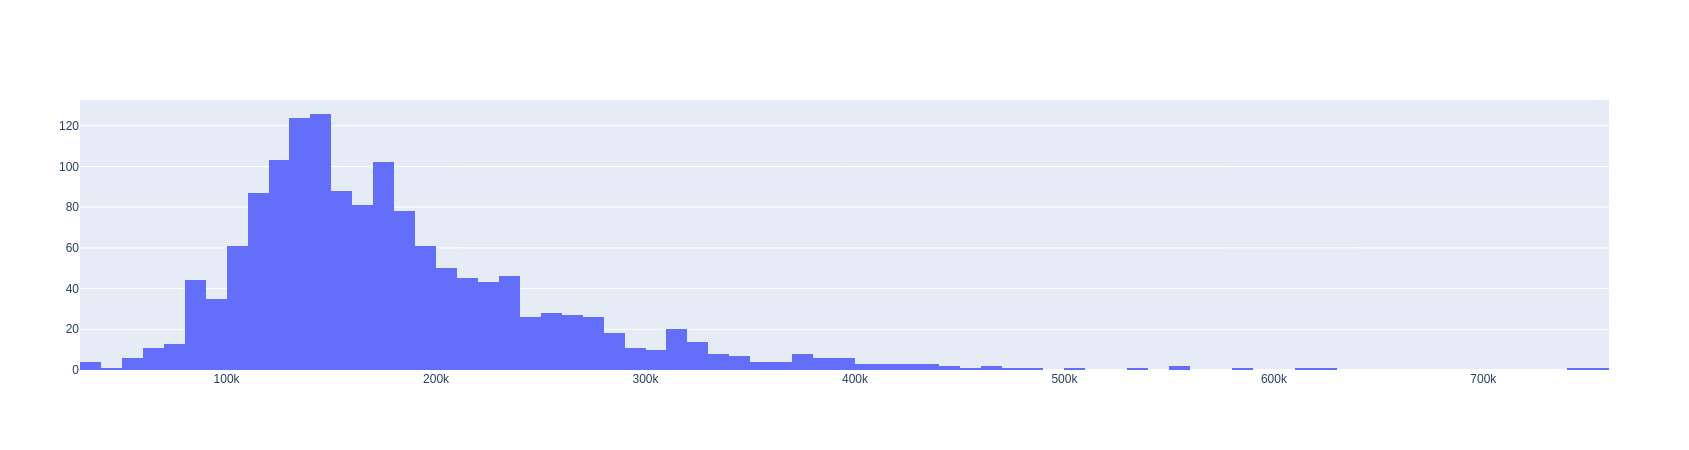

In [42]:
fig = go.Figure()

hist = go.Histogram(
    x=Y_train[y_col].values, 
    xbins=dict(
        start=0,
        end=Y_train[y_col].max(),
        size=10000,
    ),
)
fig.add_trace(hist)

fig.update_layout(
    go.Layout(
        xaxis = dict(
            rangeslider = {'visible': False},
        ),
    )
)
plotly.offline.iplot(fig)

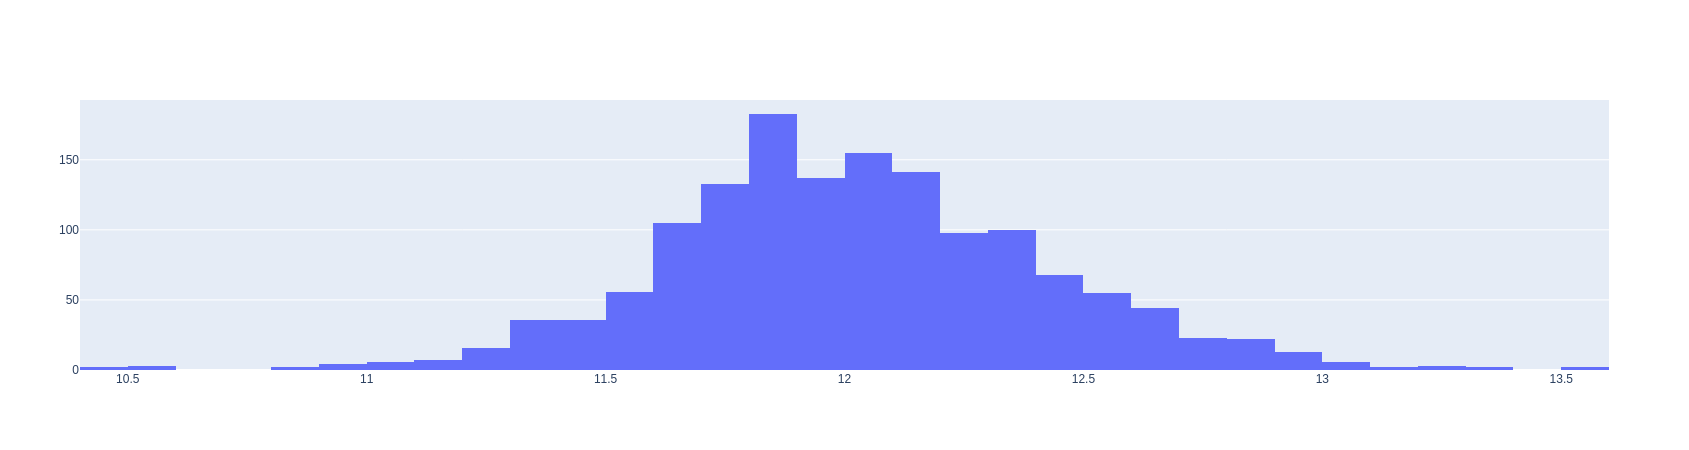

In [43]:
fig = go.Figure()

hist = go.Histogram(
    x=Y_train[log_y_col].values, 
    xbins=dict(
        start=0,
        end=Y_train[log_y_col].max(),
        size=0.10,
    ),
)
fig.add_trace(hist)

fig.update_layout(
    go.Layout(
        xaxis = dict(
            rangeslider = {'visible': False},
        ),
    )
)
plotly.offline.iplot(fig)

In [44]:
Z = X.join(Y)

Z_corr = Z.corr()

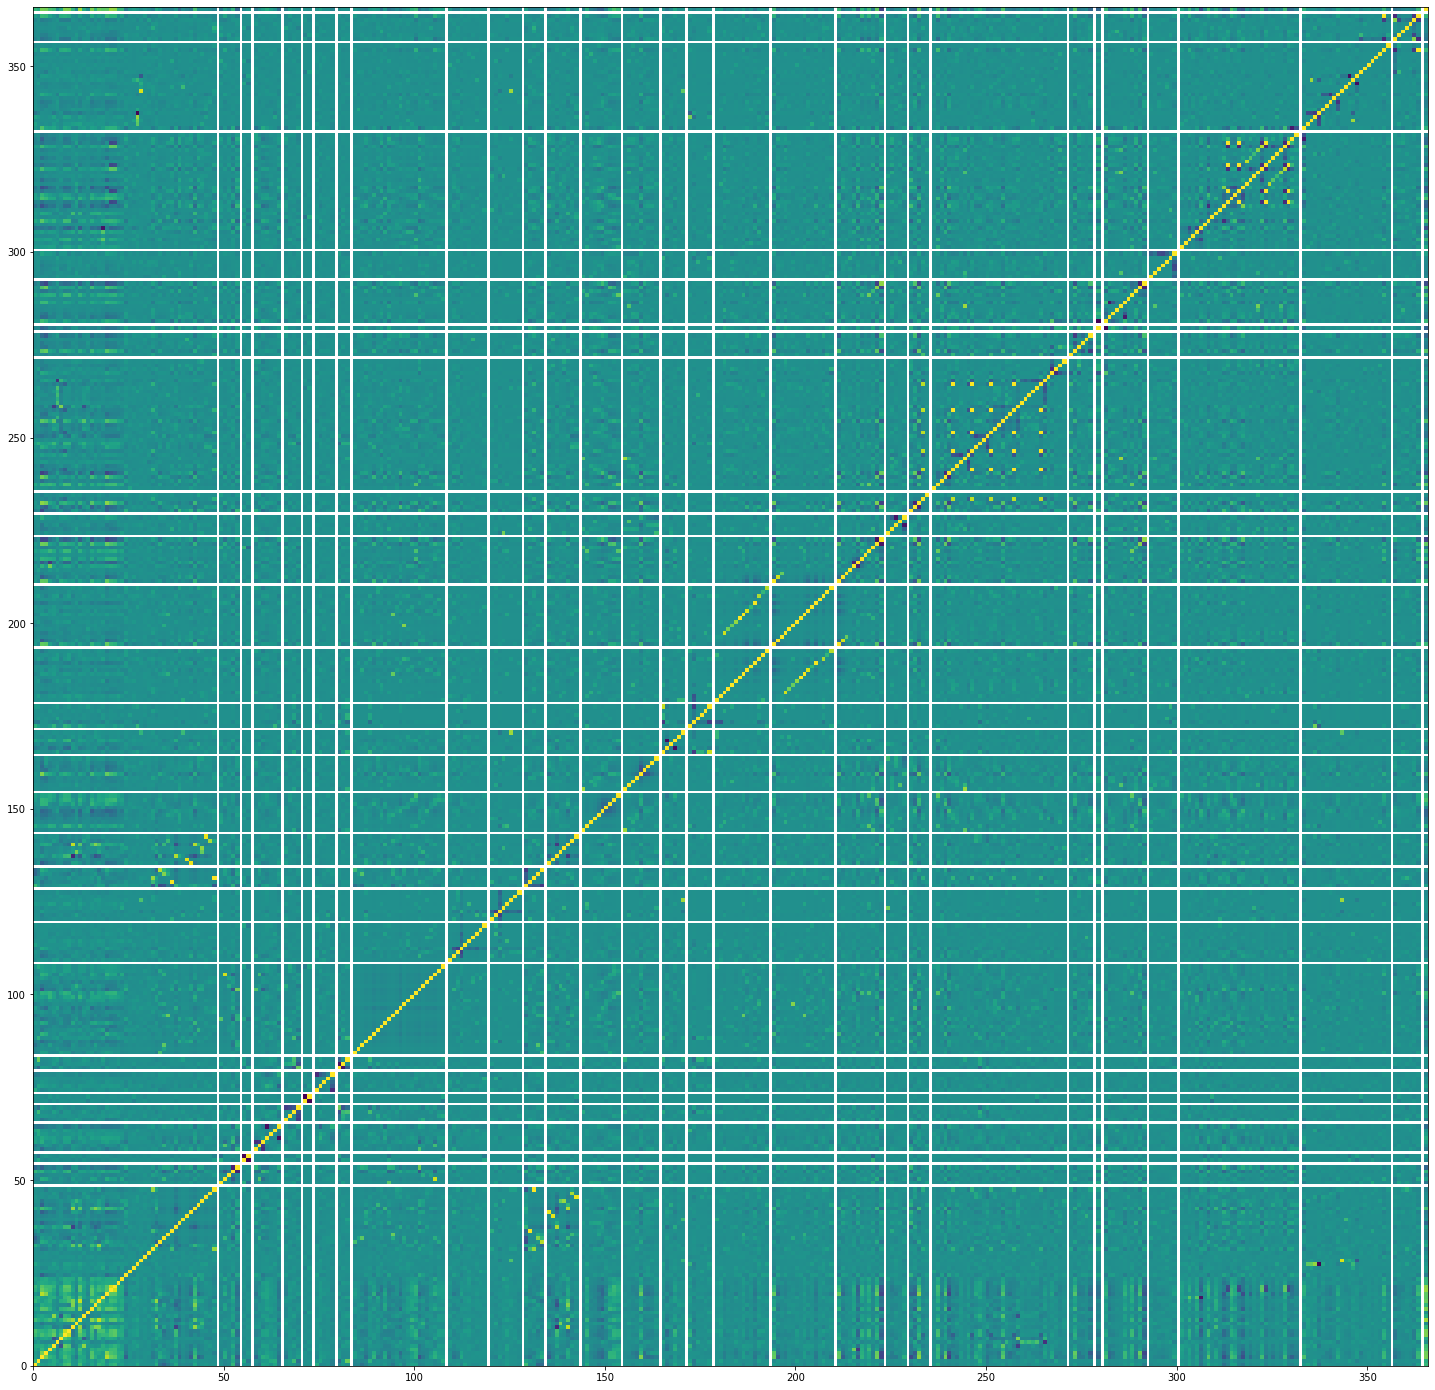

In [45]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot()
ax.pcolormesh(Z_corr)

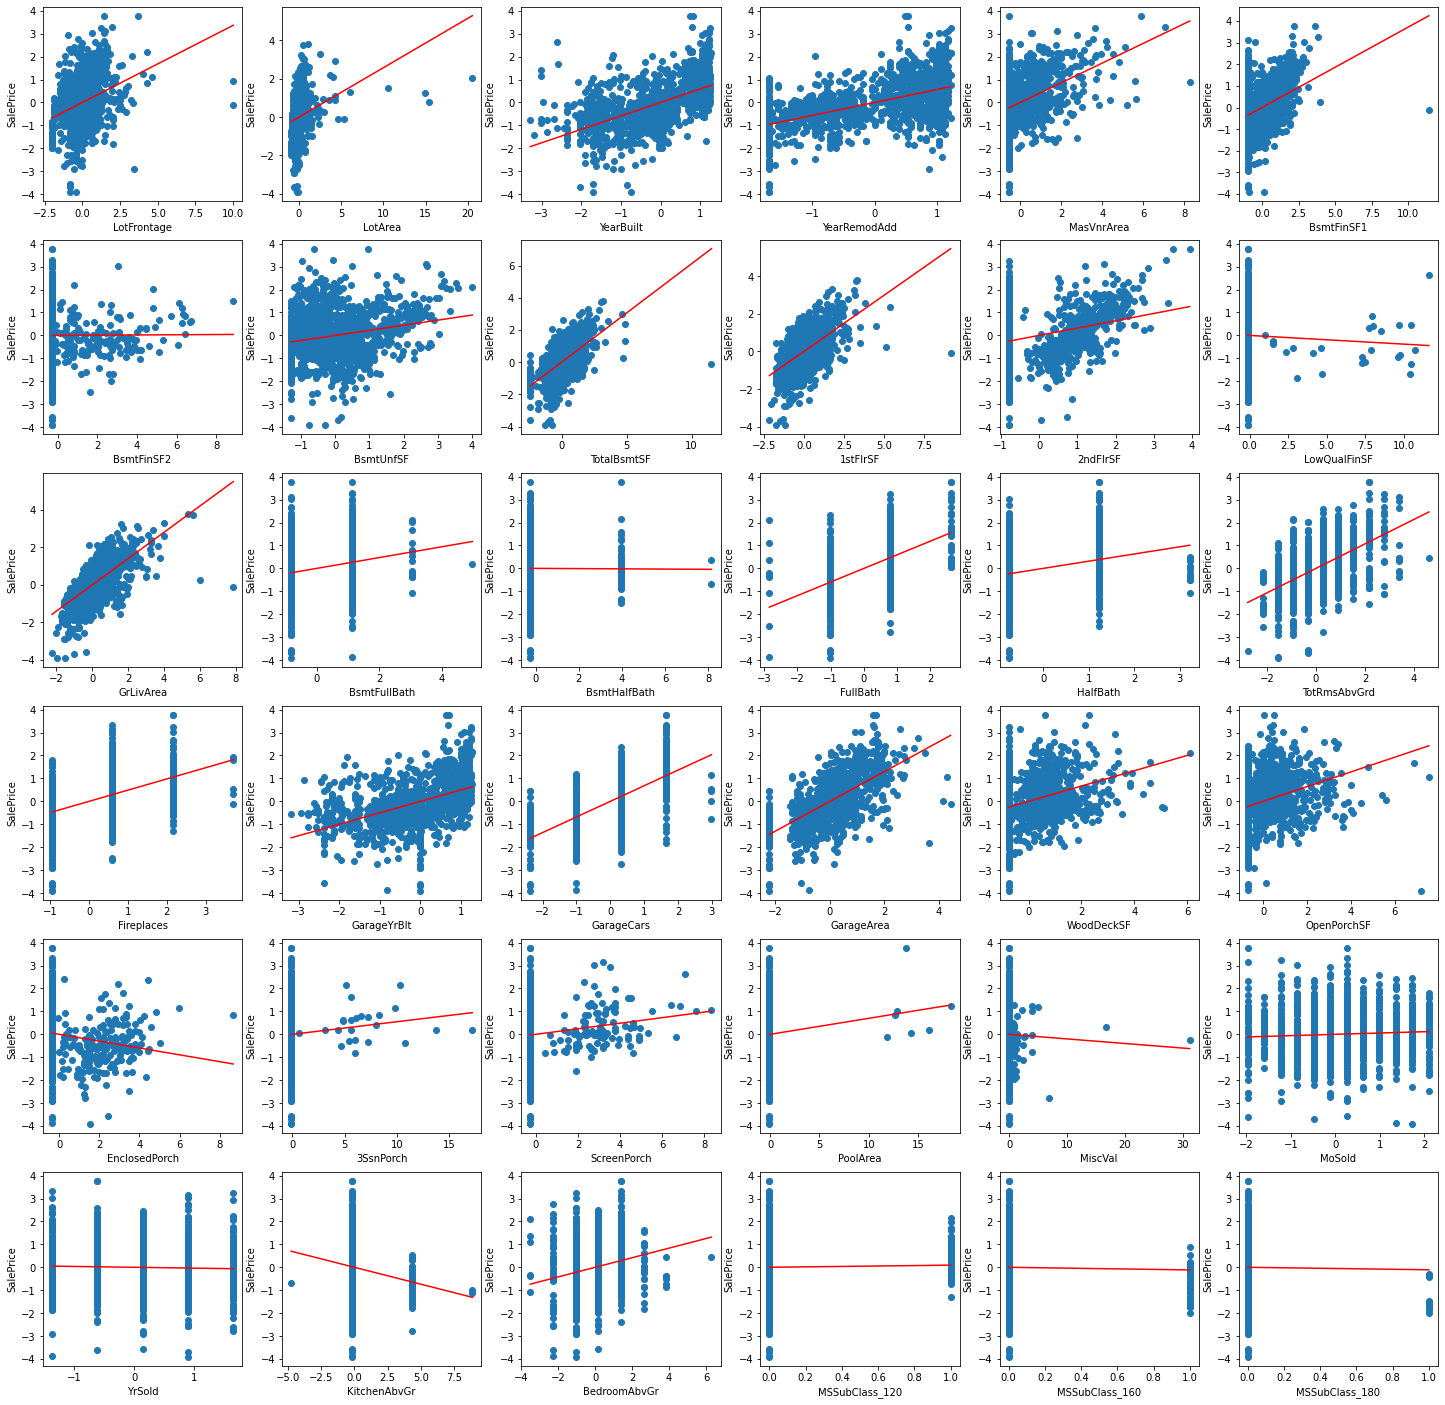

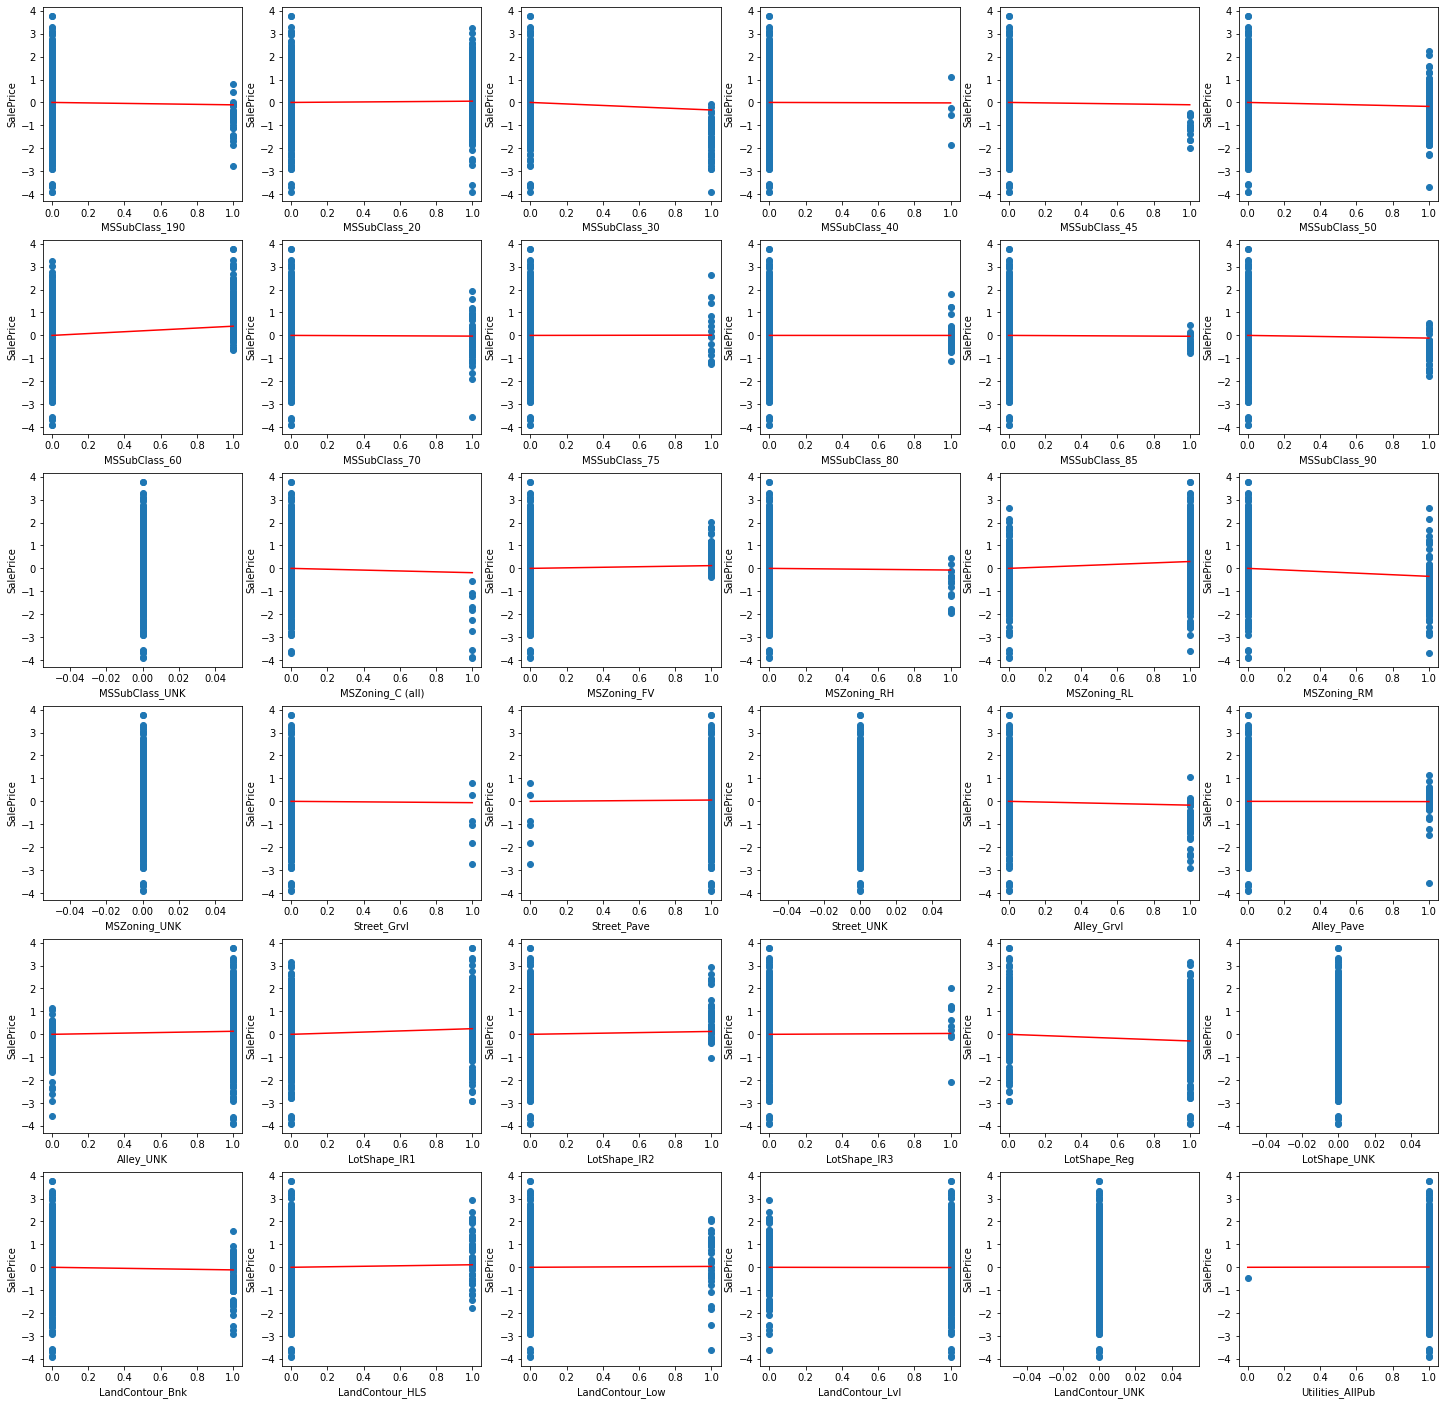

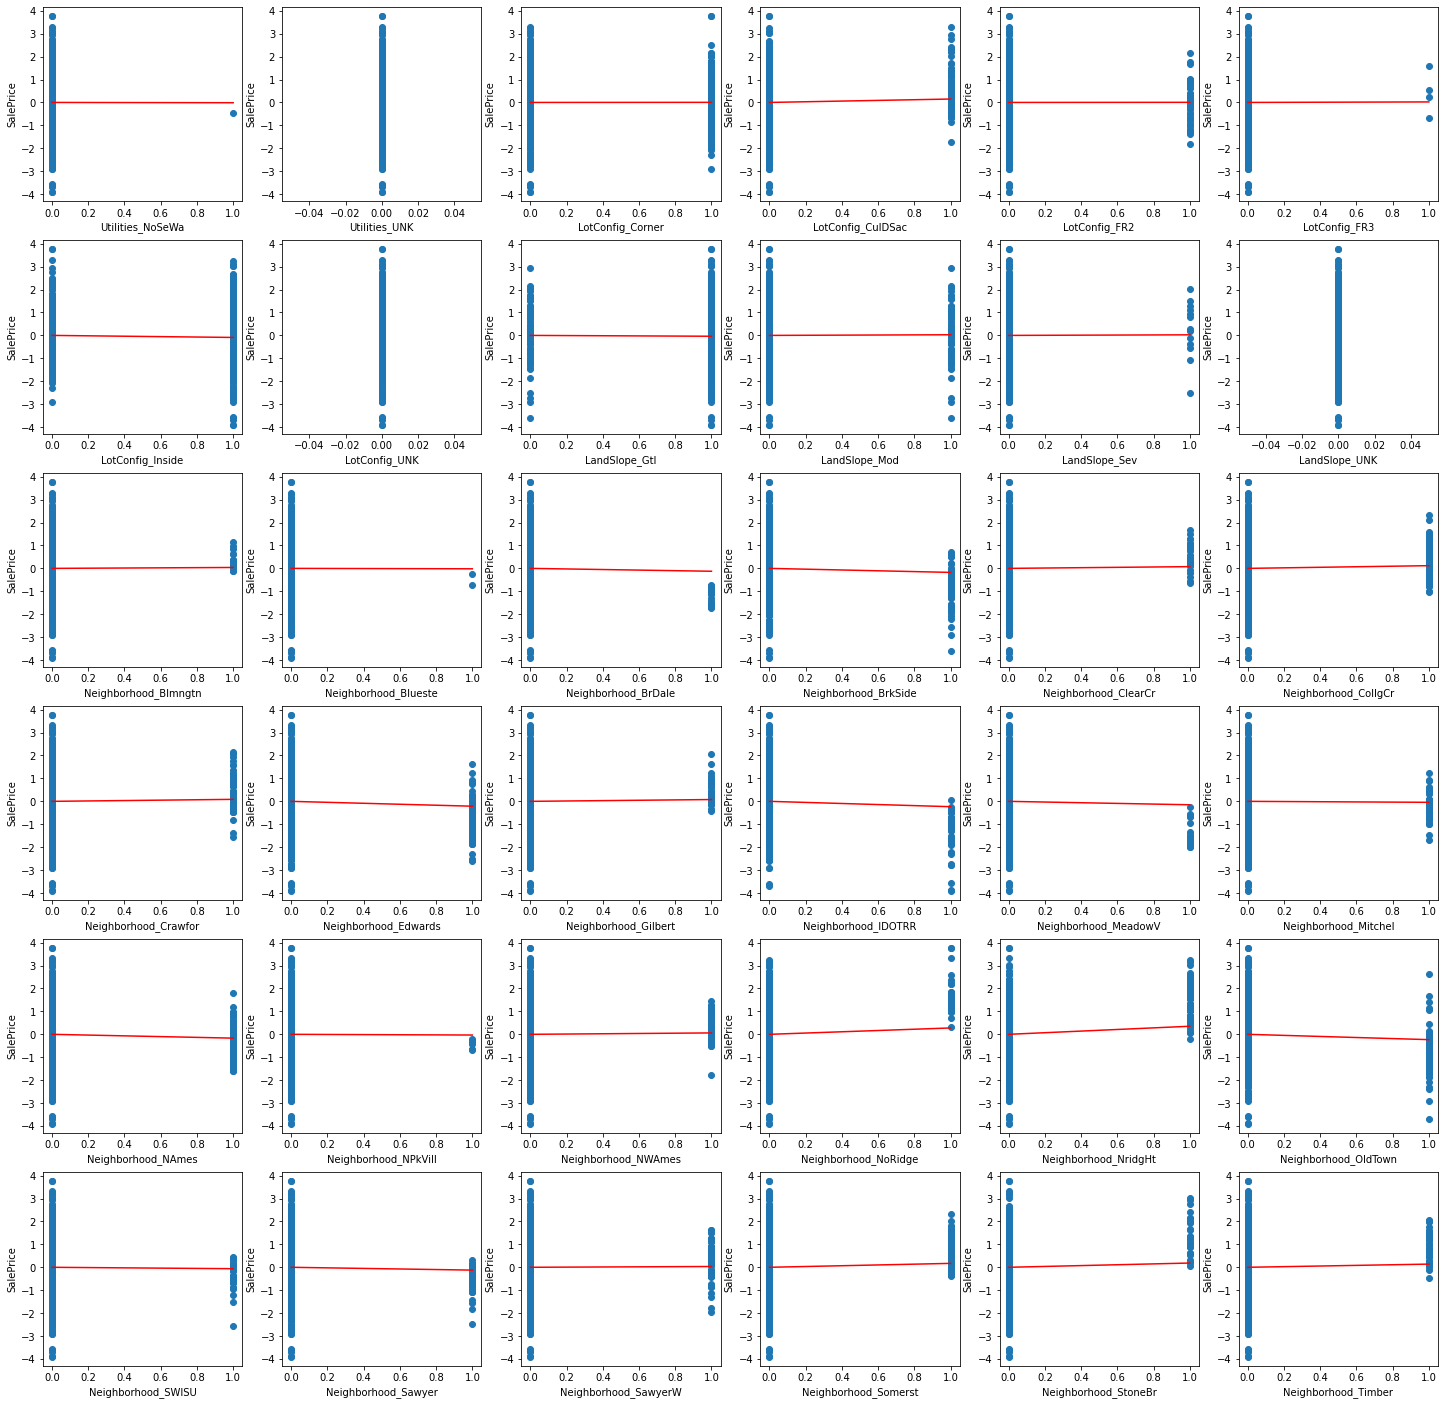

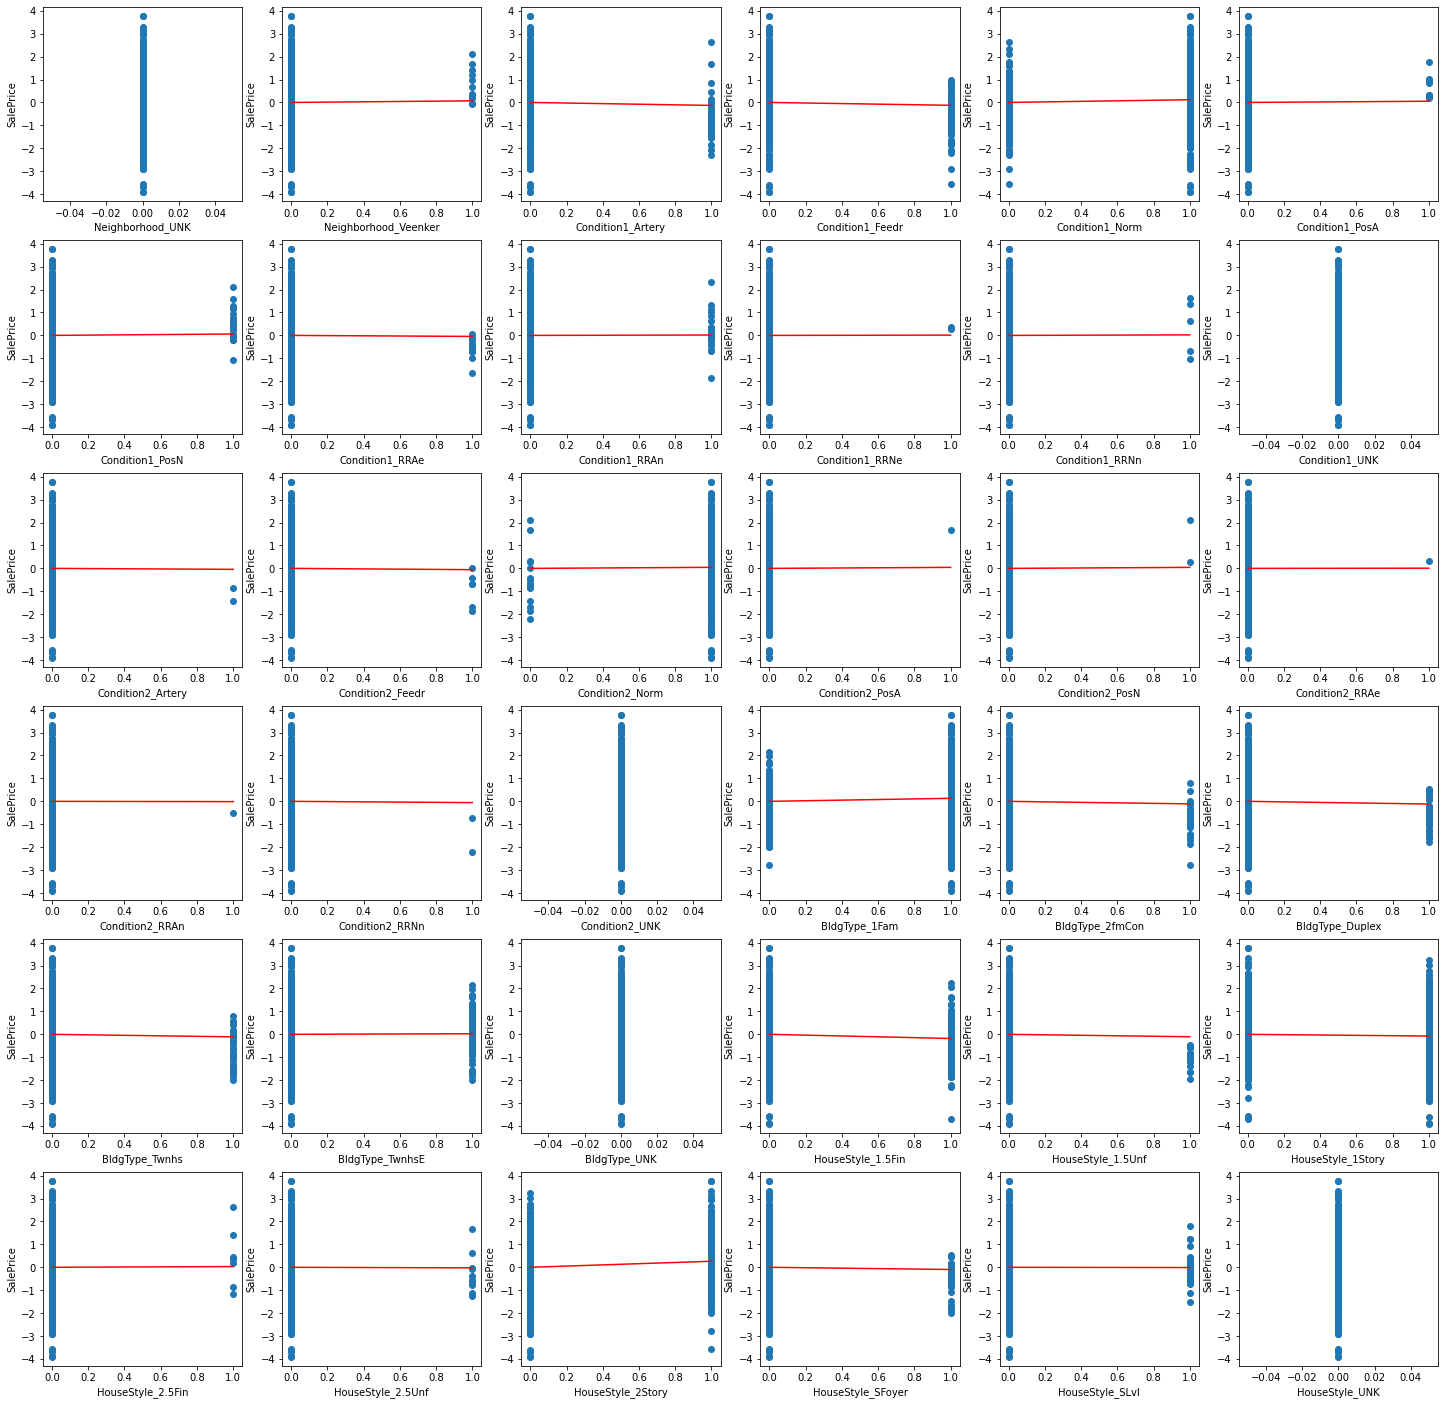

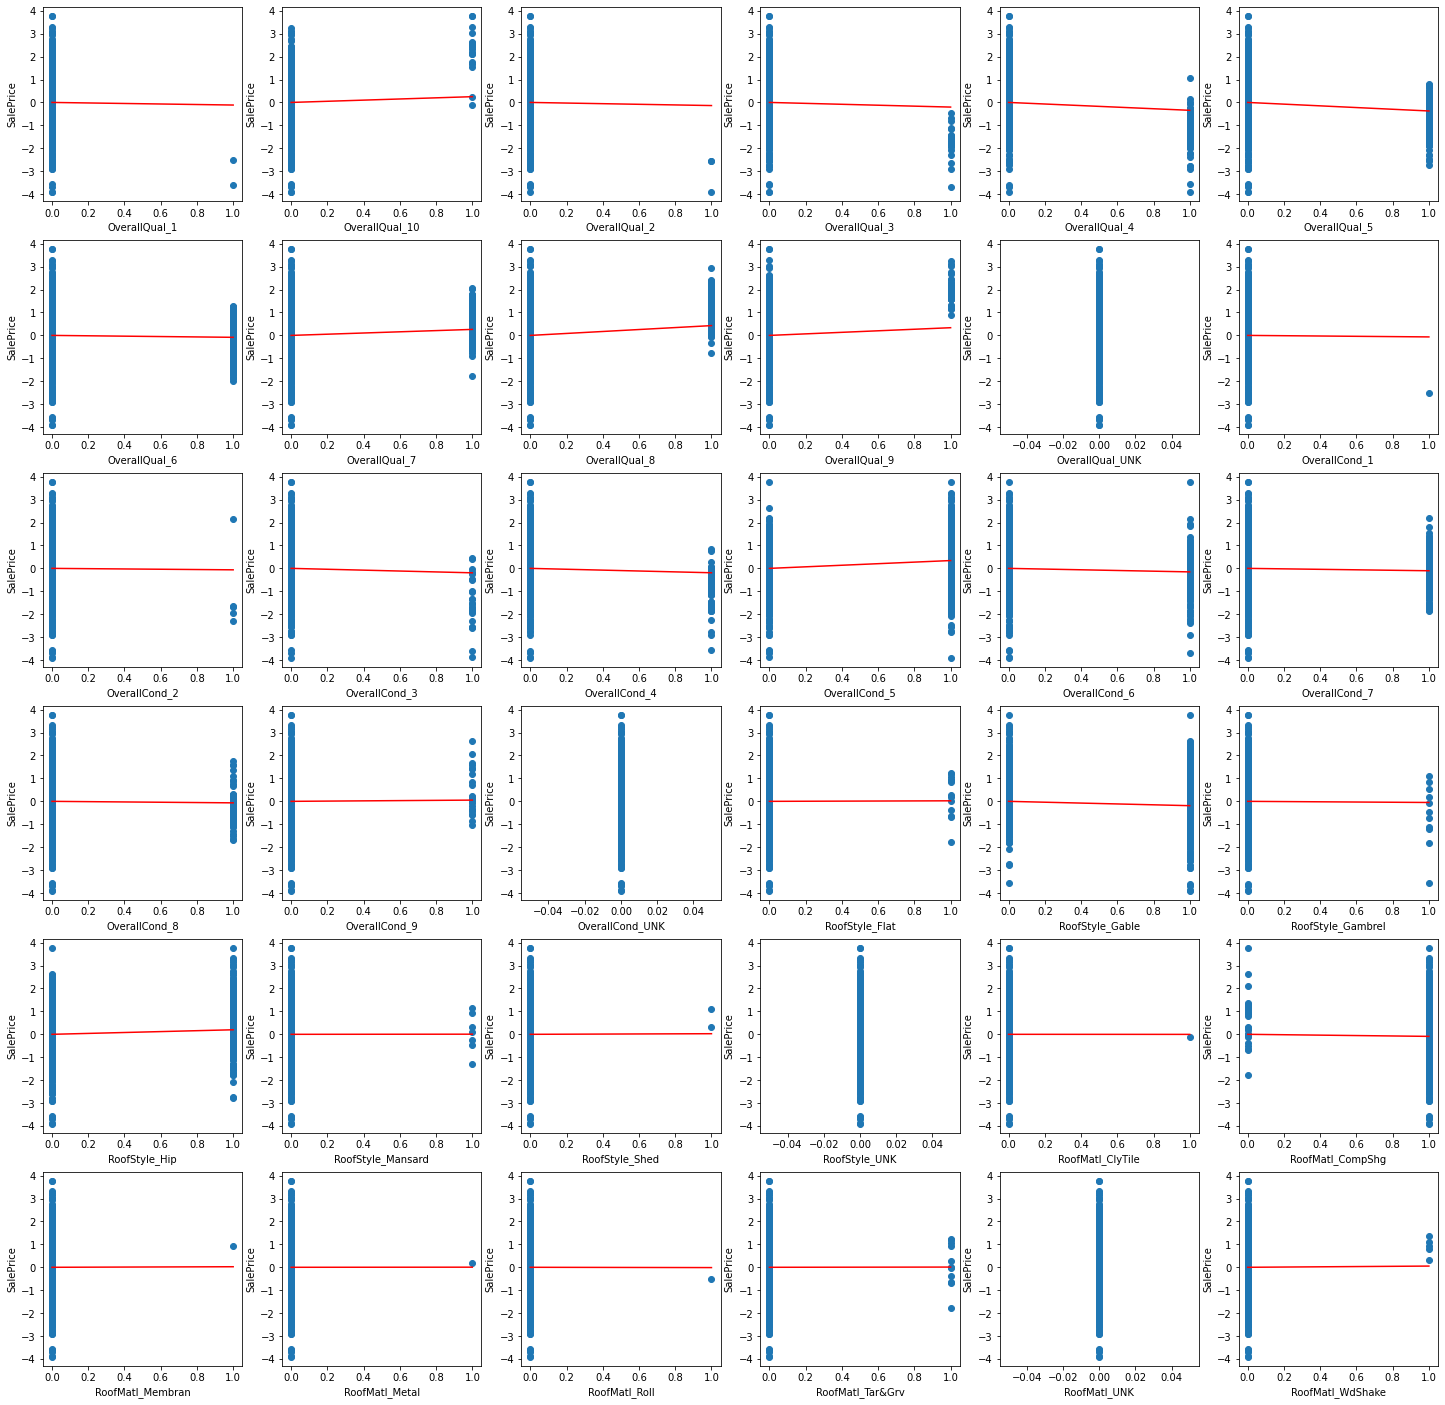

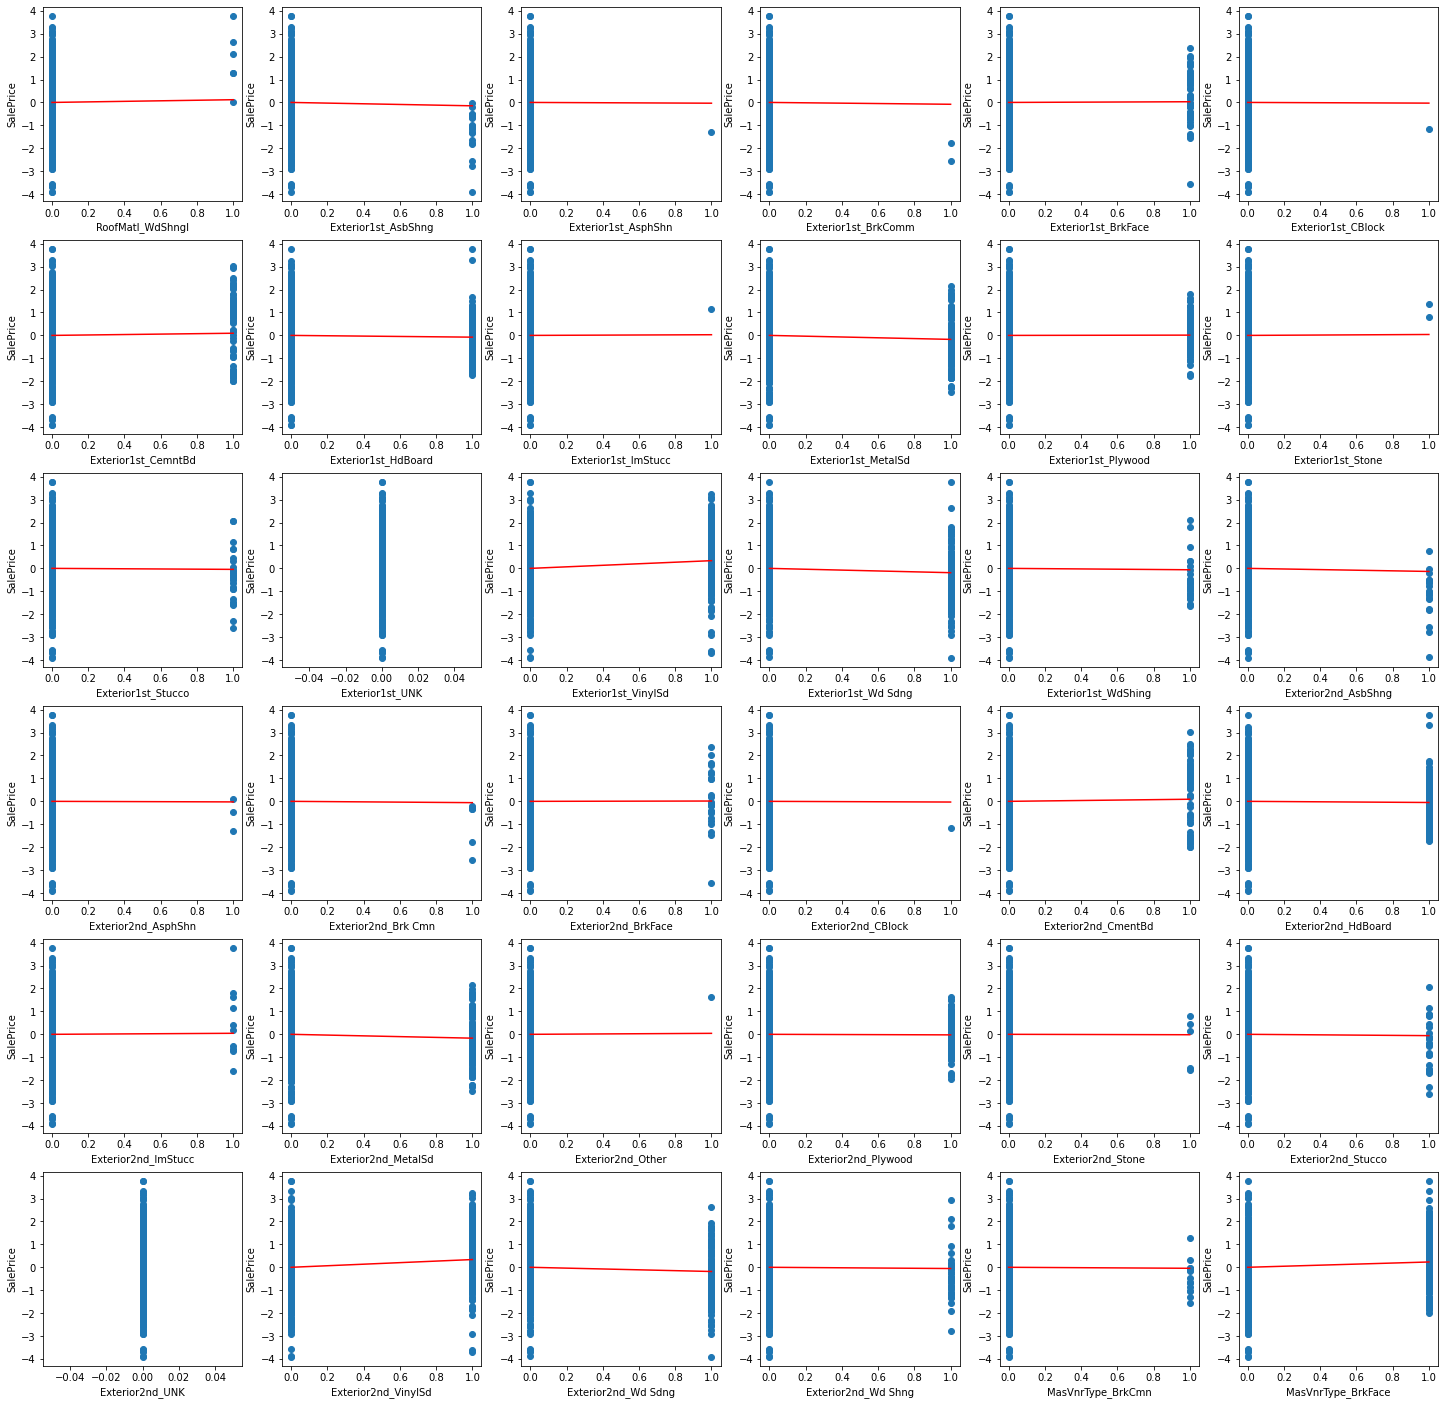

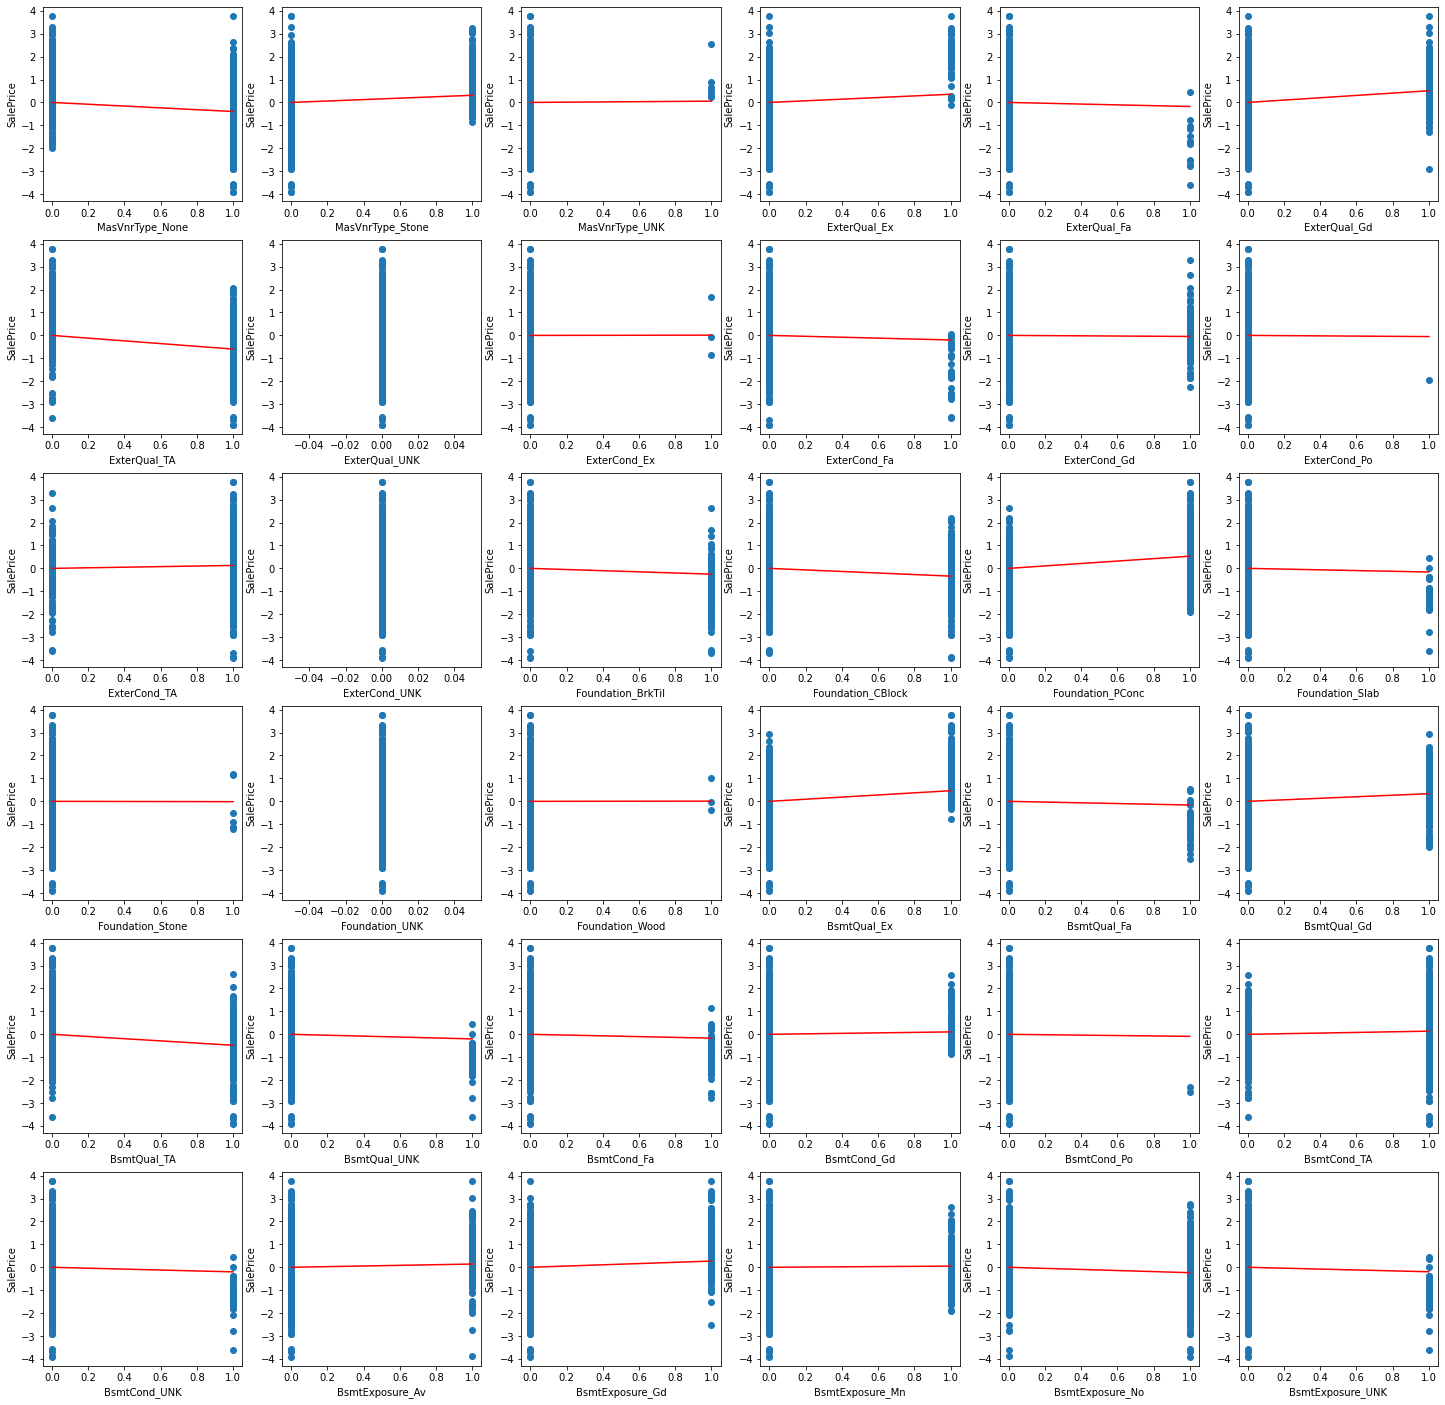

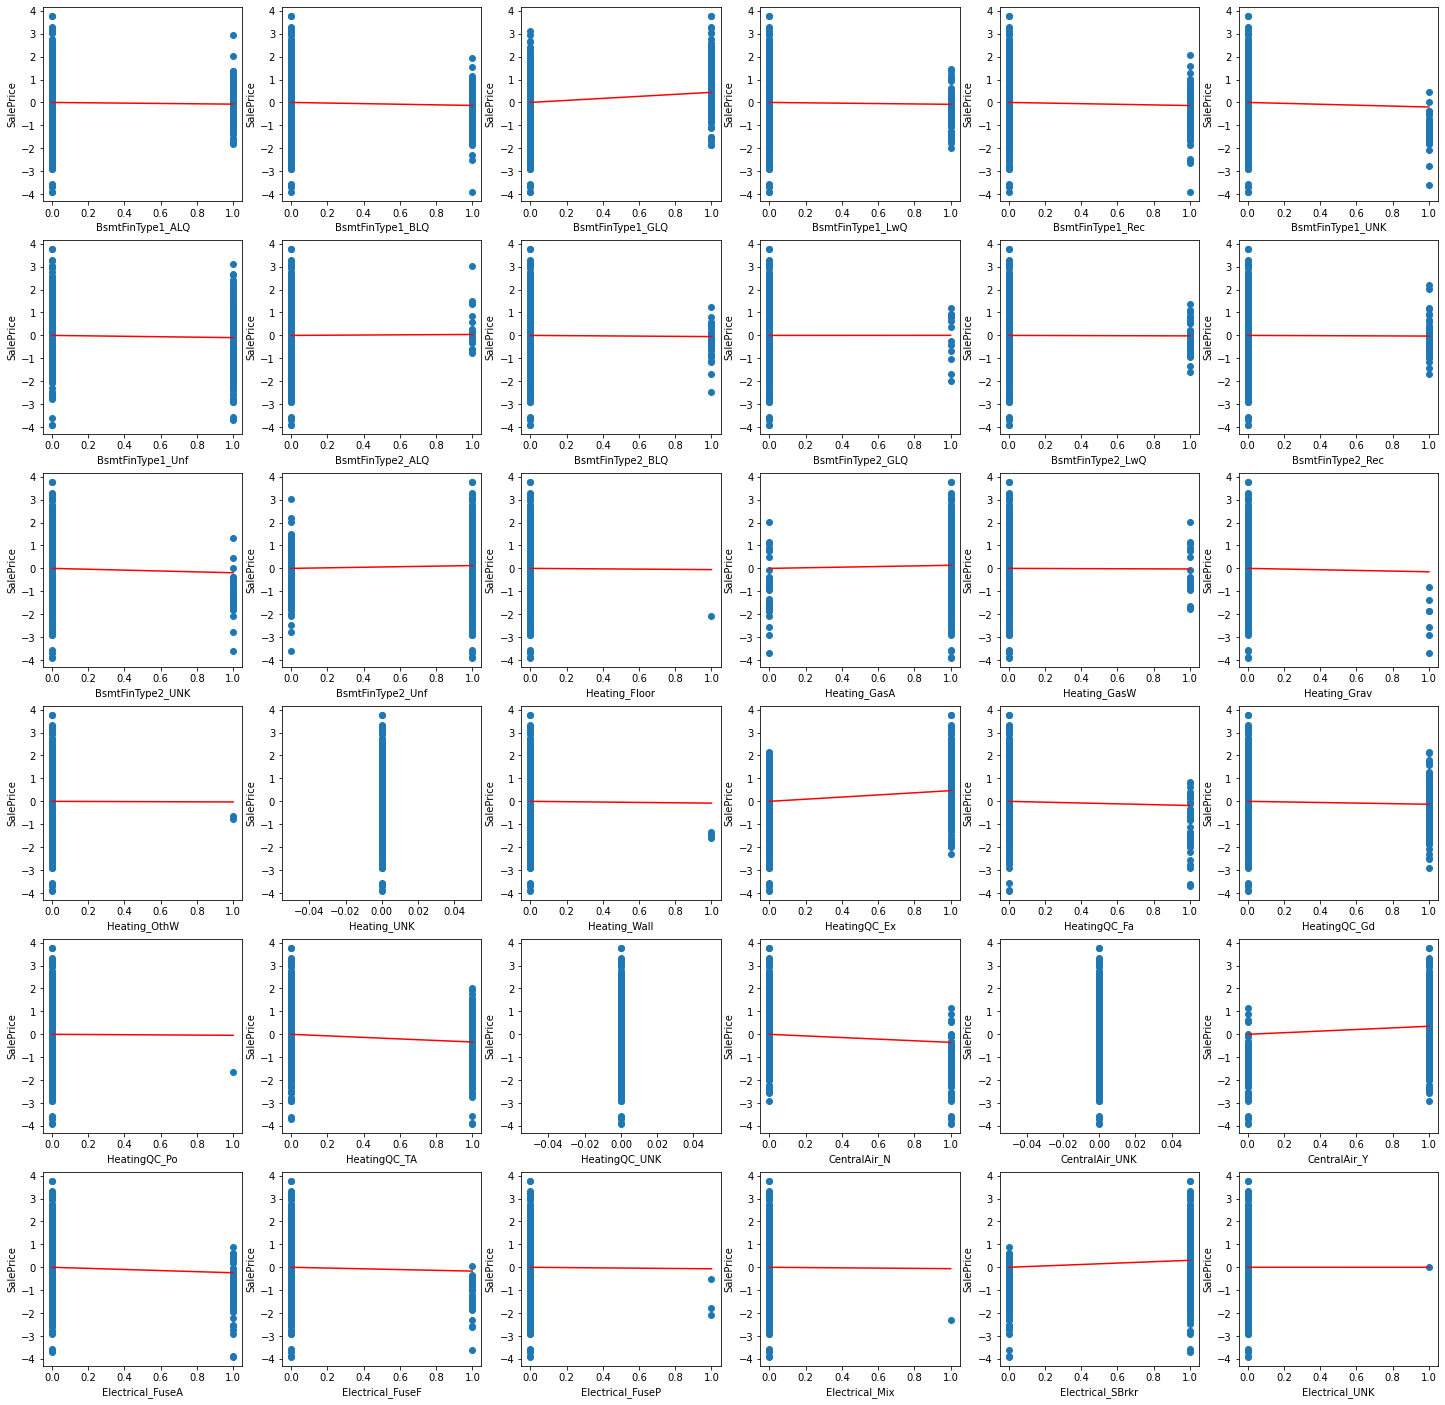

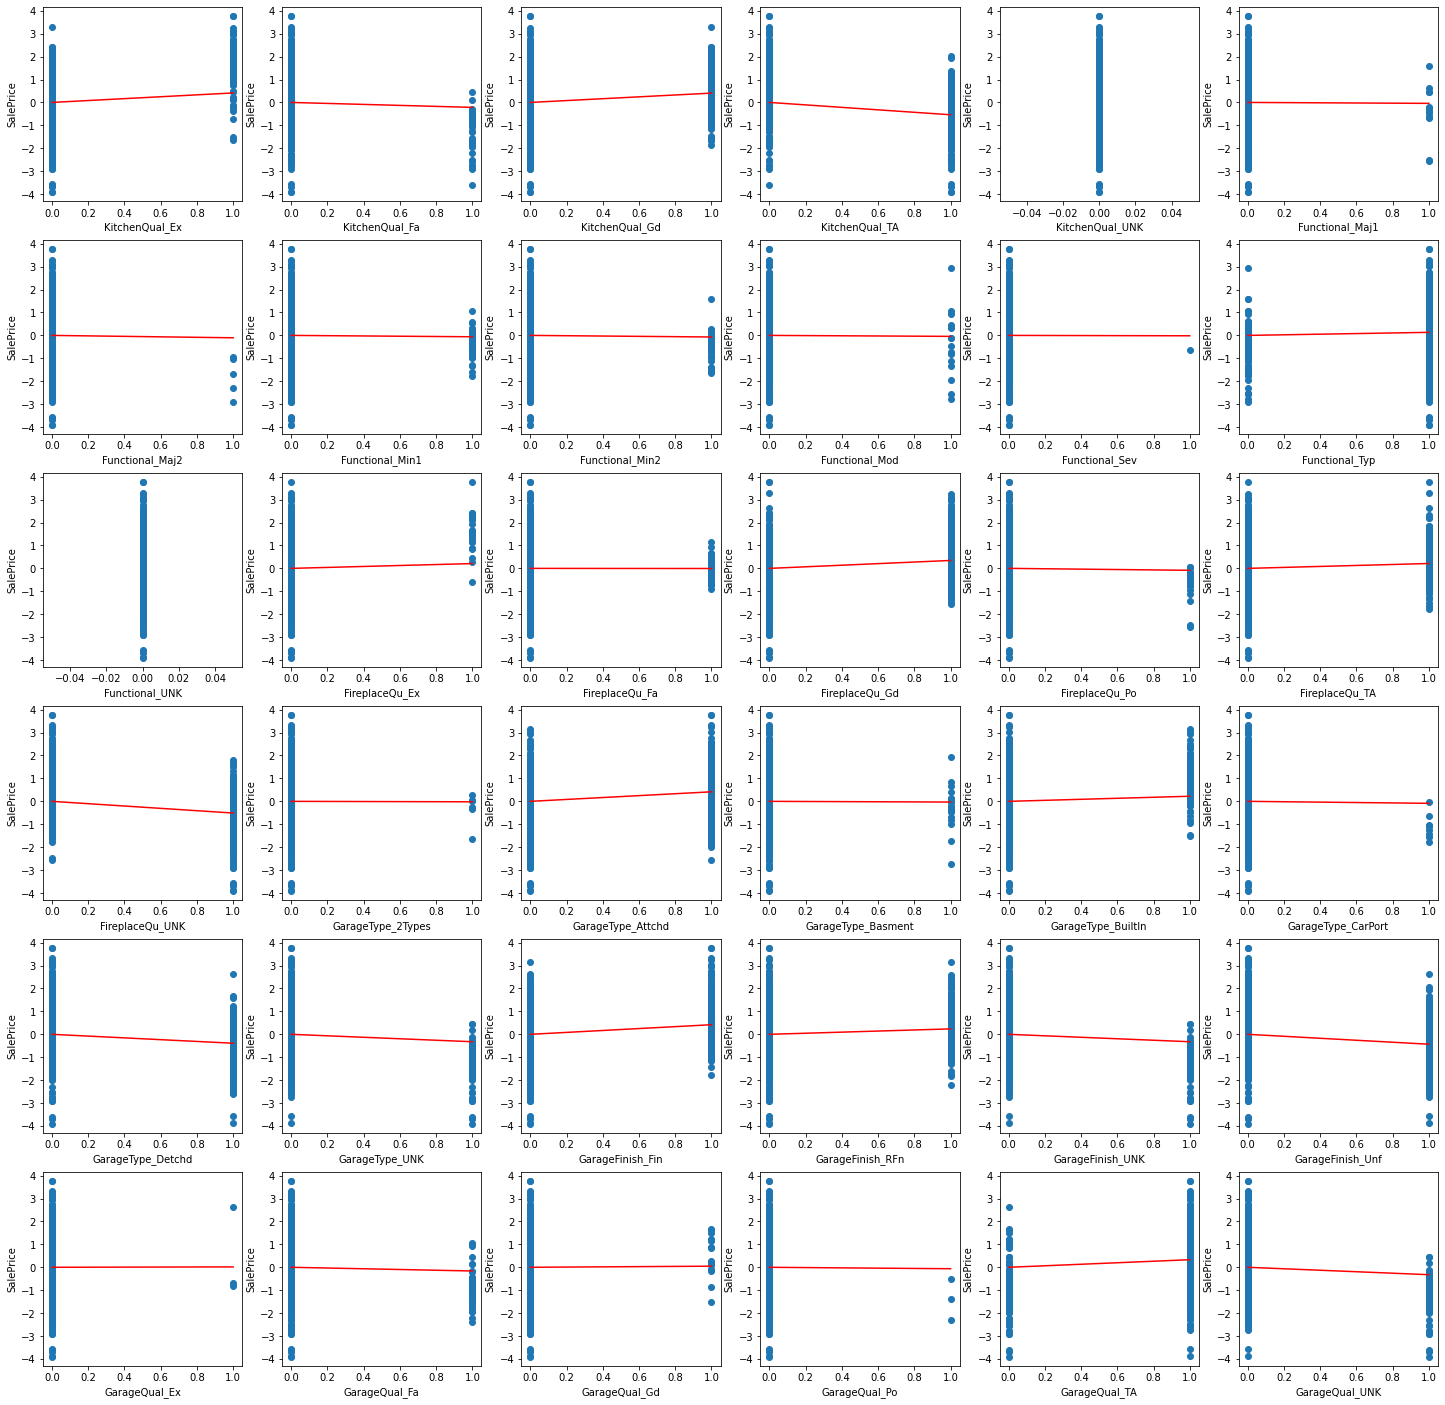

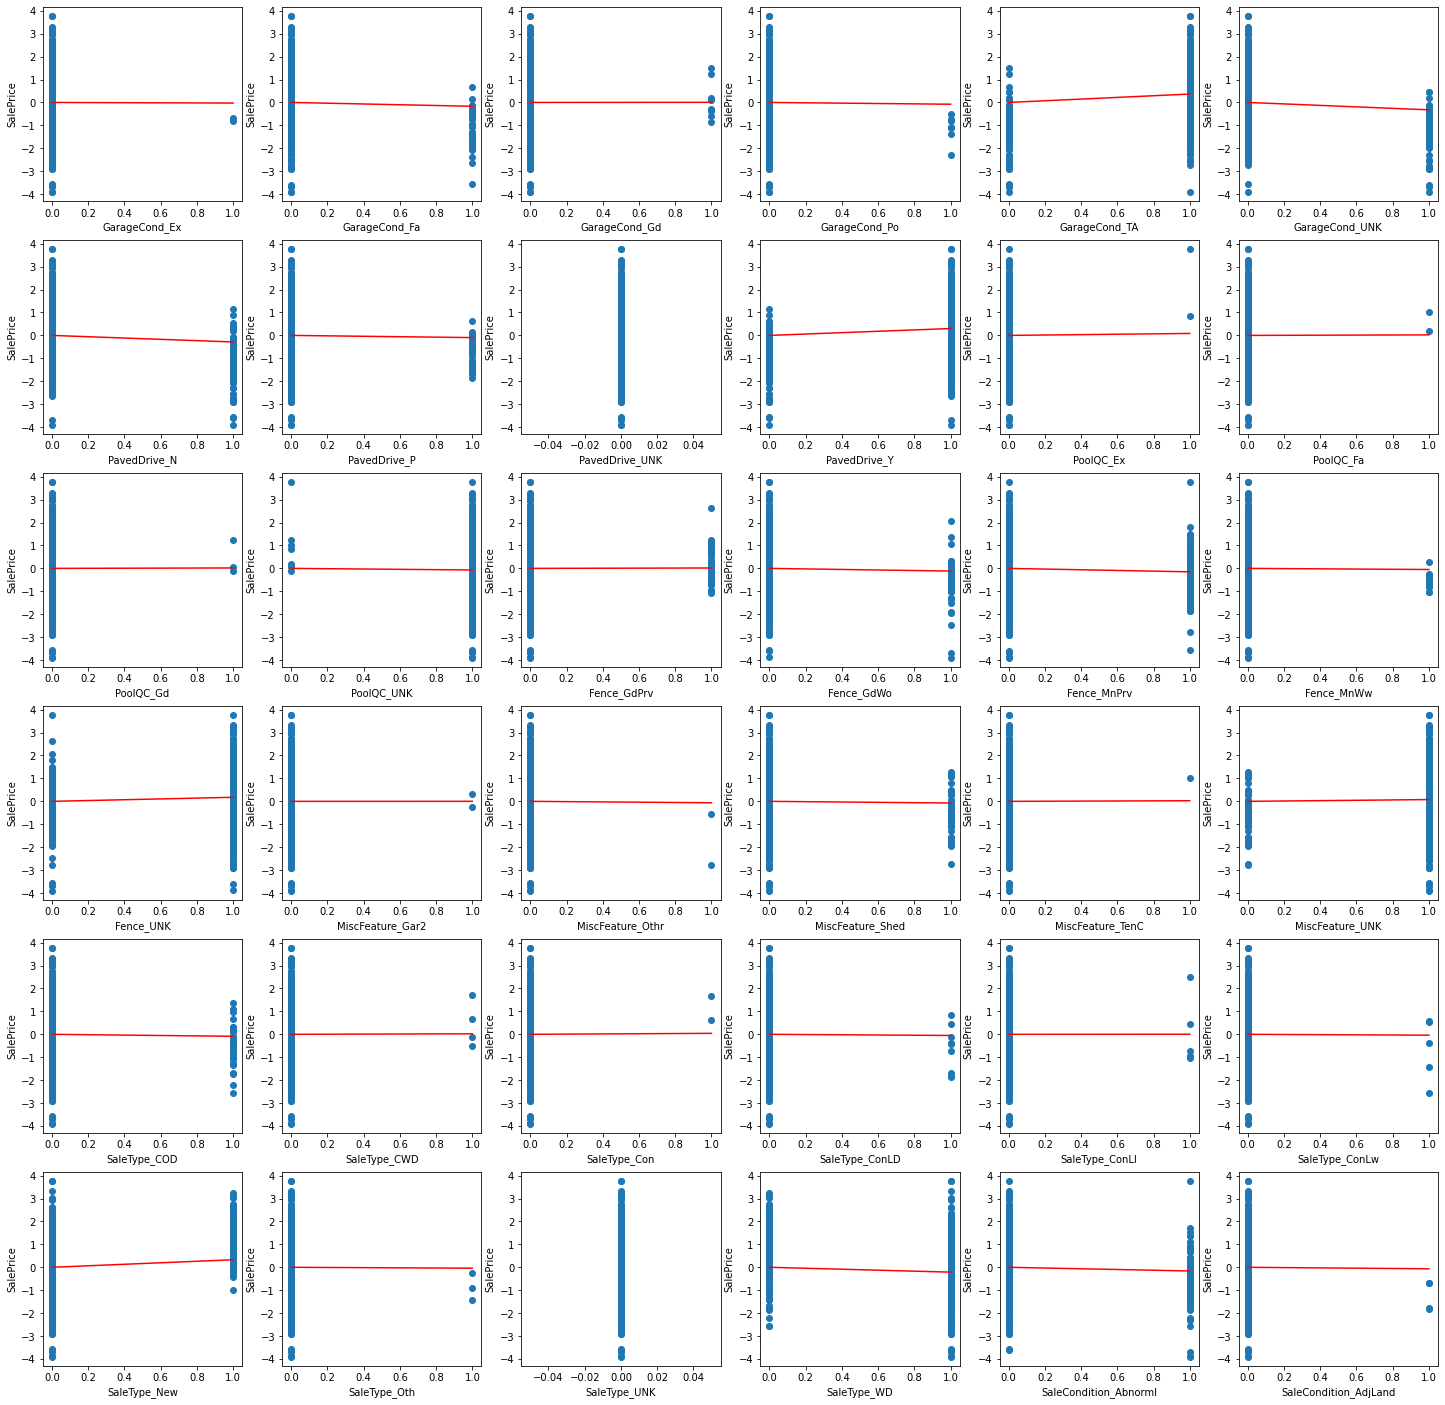

In [46]:
d = 6

for i in range(np.ceil(len(Z.columns)//(d**2)).astype(int)):

    fig = plt.figure(figsize=(25, 25))
    axs = fig.subplots(d, d)

    for j in range(d**2):
        col = Z.columns[i*d**2+j]
        
        k = j//d
        ax = axs[k, j%d]
        
        if col != y_col:
        
            cor_x = np.linspace(Z[col].min(), Z[col].max(), 3)
            s = Z_corr.at[y_col, col]
            
            ax.scatter(Z[col], Z[y_col])
             
            ax.set_xlabel(col)
            ax.set_ylabel(y_col)
            
            ax.plot(cor_x, s*cor_x, color='r')

    fig.show()

## Model Declarations

In [47]:
tf.keras.backend.set_floatx('float64')

class TFModel(tf.keras.Model):
    """
    """
    def __init__(self,
            batch_size=None,
            epochs=3,
            units0=40,
            units1=5,
    ):
        """
        """
        super(TFModel, self).__init__()

        self.batch_size = batch_size
        self.epochs = epochs
        out_dim = 1
              
        self._dense0 = tf.keras.layers.Dense(
            units0,
            activation=tf.nn.relu,
            name="dense_0",
        )
        
        self._dense1 = tf.keras.layers.Dense(
            units1,
            activation=tf.nn.relu,
            name="dense_0",
        )
        
        self._densef = tf.keras.layers.Dense(
            out_dim,
            activation=tf.nn.relu,
            name="dense_f",
        )
        
        self._optimizer = tf.keras.optimizers.Adam(
                            learning_rate=1e-4
        )
        self._metrics = [tf.keras.metrics.MeanAbsoluteError()]
        self._loss = tf.keras.losses.MeanSquaredError()
        
        self.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics,
        )
        

    def call(self, inputs):       
        """
        """
        x = self._dense0(inputs)
        x = self._dense1(x)
        out = self._densef(x)
        return out
    
    
    def fit(self, X, Y, validation_data=None):
        """
        """
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="loss",
                min_delta=1e-5,
                patience=20,
                restore_best_weights=False,
            )
        ]
        return super().fit(
            x=X,
            y=Y,
            epochs=self.epochs,
            callbacks=callbacks,
            validation_data=validation_data,
            verbose=0,
        )
    
    
    def get_params(self, **kwargs):
        """
        """
        return self.__dict__

In [48]:
models = []

In [49]:
models.extend(
    [
        sklearn.pipeline.Pipeline([
            ("projector", proj), 
            ("model", sklearn.linear_model.LinearRegression()),
        ])
        for proj in projs
    ]
)

In [50]:
tf_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        epochs=[80, 180],
        units0=[50, 500, 750],
        units1=[10, 100, 200],
    )
)
models.extend(
    [
        sklearn.pipeline.Pipeline([
            ("projector", proj), 
            ("model", TFModel(**params))
        ])
        for params in tf_param_grid for proj in projs
    ]
)

In [51]:
xgb_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        #n_estimators=[100, 110, 150],
        #max_depth=[5, 6, 8],
        learning_rate=[None, 1e-4, 1e-2],
        booster=["gbtree", "gblinear", "dart"],
        reg_alpha=[None, 1e-5, 1e-3],
        reg_lambda=[None, 1e-5, 1e-3],
    )
)
models.extend(
    [xgboost.XGBRegressor(**params) for params in xgb_param_grid]
)

In [52]:
lsvr_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        C=[1, 2, 0.5],
    )
)
models.extend(
    [sklearn.svm.LinearSVR(**params) for params in lsvr_param_grid]
)

In [53]:
svr_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        C=[1, 2, 0.5],
        kernel=["linear", "poly", "rbf", "sigmoid"],
        gamma=["scale", 0.01],
    )
)
models.extend(
    [sklearn.svm.SVR(**params) for params in svr_param_grid]
)

In [54]:
kernel_ridge_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        alpha=[1, 2, 1e-1],
        gamma=[None, 1, 0.1],
    )
)
models.extend(
    [sklearn.kernel_ridge.KernelRidge(**params) 
        for params in kernel_ridge_param_grid
    ]
)

In [55]:
elastic_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        alpha=[2, 1, 0.5],
        l1_ratio=[0.5, 1, 0.1],
    )
)
models.extend(
    [sklearn.linear_model.ElasticNet(**params) 
        for params in elastic_param_grid
    ]
)

In [56]:
gauss_process_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        kernel=[
            None, 
            sklearn.gaussian_process.kernels.Matern(),
            sklearn.gaussian_process.kernels.Matern(nu=0.5),
            sklearn.gaussian_process.kernels.Matern(nu=2.5),
            sklearn.gaussian_process.kernels.Matern(nu=np.inf),
            sklearn.gaussian_process.kernels.DotProduct(),
            sklearn.gaussian_process.kernels.RationalQuadratic(),
        ],
    )
)
models.extend(
    [
        sklearn.pipeline.Pipeline([
            ("projector", proj),
            ("model", 
                sklearn.gaussian_process.GaussianProcessRegressor(
                    **params
                )
            ),
        ])
        for params in gauss_process_param_grid for proj in projs
    ]
)

In [57]:
elastic_cv_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        l1_ratio=[0.5, 0.1, 0.7, 0.9, 0.95, 1],
    )
)
models.extend(
    [sklearn.linear_model.ElasticNetCV(**params) 
        for params in elastic_cv_param_grid
    ]
)

In [58]:
gradient_boosting_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        n_estimators=[100],
        criterion=["friedman_mse", "mse", "mae"],
        max_depth=[3, 5],
        max_features=[
            "auto",
            "sqrt", "log2"],
    )
)
models.extend(
    [sklearn.ensemble.GradientBoostingRegressor(**params)
        for params in gradient_boosting_param_grid
    ]
)

In [59]:
random_forest_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        n_estimators=[100],
        criterion=["mse", "mae"],
        max_depth=[None, 5],
        max_features=[
            "auto",
            "sqrt", "log2"],
    )
)
models.extend(
    [sklearn.ensemble.RandomForestRegressor(**params)
        for params in random_forest_param_grid
    ]
)

In [60]:
ridge_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        alpha=[1, 2, 0.5],
    )
)
models.extend(
    [sklearn.linear_model.Ridge(**params)
         for params in ridge_param_grid
    ]
)

In [61]:
bayes_adr_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        alpha_1=[1e-6, 1e-5],
        alpha_2=[1e-6, 1e-5],
        lambda_1=[1e-6, 1e-5],
        lambda_2=[1e-6, 1e-5],
    )
)
models.extend(
    [sklearn.linear_model.ARDRegression(**params)
        for params in bayes_adr_param_grid
    ]
)

In [62]:
sgd_linear_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        eta0=[0.01, 0.005],
        power_t=[0.25, 0.2],
    )
)
models.extend(
    [sklearn.linear_model.SGDRegressor(**params)
        for params in sgd_linear_param_grid
    ]
)

In [63]:
ada_boost_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        base_estimator=[
            None,
            sklearn.tree.DecisionTreeRegressor(max_depth=4),
        ],
        loss=["linear", "square", "exponential"],
    )
)
models.extend(
    [sklearn.ensemble.AdaBoostRegressor(**params)
        for params in ada_boost_param_grid
    ]
)

In [64]:
bagging_param_grid = sklearn.model_selection.ParameterGrid(
    dict(
        n_estimators=[10, 20],
        max_features=[1.0, 0.2],
        bootstrap=[True, False],
    )
)
models.extend(
    [sklearn.ensemble.BaggingRegressor(**params)
        for params in bagging_param_grid
    ]
)

## Training

In [65]:
pred_cols = [f"model_{i:03d}" for i in range(len(models))]
    
scores = []

kf_cols = ["r2", "mse", "test_mse"]

for model in models:
    t1 = time.perf_counter()
    row = []
    
    X_train_split, X_test_split, y_train_split, y_test_split = (
        sklearn.model_selection.train_test_split(
            X, 
            Y,
            test_size=0.2, 
            #random_state=0,
        )
    )
    
    validation_data = (X_test_split, y_test_split)
    
    model.fit(X_train_split, y_train_split)       
    pred = model.predict(X)
    r2 = sklearn.metrics.r2_score(Y[y_col], pred)
    mse = sklearn.metrics.mean_squared_error(Y[y_col], pred)

    test_mse = sklearn.metrics.mean_squared_error(
        y_test_split, 
        model.predict(X_test_split),
    )
    
    row.append(r2)
    row.append(mse)
    row.append(test_mse)
    
    t2 = time.perf_counter()
    row.append(t2-t1)
    scores.append(row)
    log.info(f"{str(model)[:15]} -- time elapsed: {t2-t1:5.3f}")

2020-12-02 22:50:08,004 - __main__ - INFO - Pipeline(steps= -- time elapsed: 0.561
2020-12-02 22:50:08,113 - __main__ - INFO - Pipeline(steps= -- time elapsed: 0.104
2020-12-02 22:50:08,167 - __main__ - INFO - Pipeline(steps= -- time elapsed: 0.050
2020-12-02 22:50:08,223 - __main__ - INFO - Pipeline(steps= -- time elapsed: 0.051
2020-12-02 22:50:08,303 - __main__ - INFO - Pipeline(steps= -- time elapsed: 0.074
2020-12-02 22:50:08,370 - __main__ - INFO - Pipeline(steps= -- time elapsed: 0.062
2020-12-02 22:50:10,543 - __main__ - INFO - Pipeline(steps= -- time elapsed: 2.166
2020-12-02 22:50:12,584 - __main__ - INFO - Pipeline(steps= -- time elapsed: 2.038
2020-12-02 22:50:14,623 - __main__ - INFO - Pipeline(steps= -- time elapsed: 2.036
2020-12-02 22:50:16,867 - __main__ - INFO - Pipeline(steps= -- time elapsed: 2.243
2020-12-02 22:50:19,170 - __main__ - INFO - Pipeline(steps= -- time elapsed: 2.301
2020-12-02 22:50:21,538 - __main__ - INFO - Pipeline(steps= -- time elapsed: 2.366
2020

## Record Results

In [66]:
cv_df = pd.DataFrame(scores, index=pred_cols, columns=kf_cols+["time"])

cv_df["name"] = [str(model) for model in models]
cv_df['params'] = [model.get_params() for model in models]

In [67]:
cv_df.head(3)

,r2,mse,test_mse,time,name,params
model_000,8.992218e-01,1.007782e-01,2.077369e-01,0.561125,"Pipeline(steps=[('projector',\n PCA(n_components=150, svd_solver='randomized', whiten=True)),\n ('model', LinearRegression())])","{'memory': None, 'steps': [('projector', PCA(n_components=150, svd_solver='randomized', whiten=True)), ('model', LinearRegression())], 'verbose': False, 'pr..."
model_001,9.000969e-01,9.990313e-02,1.257365e-01,0.103671,"Pipeline(steps=[('projector', FeatureAgglomeration(n_clusters=150)),\n ('model', LinearRegression())])","{'memory': None, 'steps': [('projector', FeatureAgglomeration(n_clusters=150)), ('model', LinearRegression())], 'verbose': False, 'projector': FeatureAgglom..."
model_002,-4.057319e+19,4.057319e+19,2.028660e+20,0.049749,"Pipeline(steps=[('projector',\n SelectPercentile(percentile=50,\n score_func=<function f_regression at 0x7f...","{'memory': None, 'steps': [('projector', SelectPercentile(percentile=50, score_func=<function f_regression at 0x7fe8d1f979d0>)), ('model', ..."


In [68]:
cv_df.sort_values(by=['test_mse'], ascending=True).head(20)

,r2,mse,test_mse,time,name,params
model_261,0.987692,0.012308,0.061542,3.033665,"Pipeline(steps=[('projector',\n SelectPercentile(percentile=80,\n score_func=<function f_regression at 0x7f...","{'memory': None, 'steps': [('projector', SelectPercentile(percentile=80, score_func=<function f_regression at 0x7fe8d1f979d0>)), ('model', ..."
model_324,0.939850,0.060150,0.065518,1.790928,"ARDRegression(lambda_1=1e-05, lambda_2=1e-05)","{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-05, 'lambda_2': 1e-05, 'n_iter': 300, 'no..."
model_255,0.986505,0.013495,0.067474,2.231202,"Pipeline(steps=[('projector',\n SelectPercentile(percentile=80,\n score_func=<function f_regression at 0x7f...","{'memory': None, 'steps': [('projector', SelectPercentile(percentile=80, score_func=<function f_regression at 0x7fe8d1f979d0>)), ('model', ..."
model_282,0.926836,0.073164,0.070814,0.477002,ElasticNetCV(),"{'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'norma..."
model_331,0.939022,0.060978,0.073247,0.766573,"ARDRegression(alpha_1=1e-05, lambda_1=1e-05)","{'alpha_1': 1e-05, 'alpha_2': 1e-06, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-05, 'lambda_2': 1e-06, 'n_iter': 300, 'no..."
model_278,0.985230,0.014770,0.073814,11.694417,"Pipeline(steps=[('projector',\n SelectPercentile(percentile=50,\n score_func=<function f_regression at 0x7f...","{'memory': None, 'steps': [('projector', SelectPercentile(percentile=50, score_func=<function f_regression at 0x7fe8d1f979d0>)), ('model', ..."
model_327,0.940080,0.059920,0.074591,1.169461,"ARDRegression(alpha_2=1e-05, lambda_1=1e-05)","{'alpha_1': 1e-06, 'alpha_2': 1e-05, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-05, 'lambda_2': 1e-06, 'n_iter': 300, 'no..."
model_145,0.940843,0.059157,0.075886,0.135690,"XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n ...","{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gblinear', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, '..."
model_336,0.939238,0.060762,0.076688,1.352949,"ARDRegression(alpha_1=1e-05, alpha_2=1e-05, lambda_1=1e-05, lambda_2=1e-05)","{'alpha_1': 1e-05, 'alpha_2': 1e-05, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-05, 'lambda_2': 1e-05, 'n_iter': 300, 'no..."
model_146,0.933438,0.066562,0.077207,0.132279,"XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n ...","{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gblinear', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, '..."


In [69]:
model_name = cv_df.sort_values(by=['test_mse'], ascending=True).index[0]
model = models[int(model_name[-3:])]

In [70]:
results = pd.DataFrame({"Id": df_test["Id"], "SalePrice": model.predict(X_test).reshape(-1)})

In [71]:
results_to_file = results.copy()
results_to_file["SalePrice"] = np.exp(preprocessor.y_scl.inverse_transform(results_to_file["SalePrice"]))

In [72]:
results_to_file.head(3)

,Id,SalePrice
0,1461,107059.768076
1,1462,151746.830245
2,1463,169706.712213


In [73]:
results_fn = os.path.join(data_dir, "results.csv")
results_to_file.to_csv(results_fn, index=False)